**Pokemon Image Classifcation with CNN for Explainability**

This is a image classification task. the same model architecture was applied on three datasets,

1. the original dataset
2. The dominant classes in the dataset
3. The artifical created images from the original dataset to increase the number of images.

The performances of the three set-ups were displayed with confusion matrix and classification report, after which a random image was generated from the dataset for the model to predict. Finally we applied Grad-CAM to visualize the images predicted by the model.

**We import all the necessary libraries in the below section**

In [ ]:
!pip install tf-explain # for grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.1 MB/s eta 0:00:00


In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import math
import cv2
import seaborn as sns
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
#GradCAM
from tf_explain.core.grad_cam import GradCAM
# scikit learn libries
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
#tensorflow libraries
from tensorflow.keras import backend, callbacks
from tensorflow.keras import layers, models, callbacks, optimizers, applications, experimental, losses, utils
from PIL import Image
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.optimizers import Adam, SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Display images using OpenCV
from google.colab.patches import cv2_imshow

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

**Mount the Drive**

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')

**Definition of Functions**

In [ ]:
# To visualize classes of the data
def plot(images, labels, predictions = None):


    n_cols = min(3, len(images)) # Define the number of columns and rows for the subplots.
    n_rows = math.ceil(len(images) / n_cols) # At most 3 columns and rows are calculated based on the number of images.
    fig, axes = plt.subplots(n_rows, n_cols, figsize = (12,3)) # Create a grid of subplots with the defined number of rows and columns.

    if predictions is None: # If no predictions are given, create an empty predictions list of the same length as labels.

        predictions = [None] * len(labels)


    for i, (x, y_true, y_pred) in enumerate(zip(images, labels, predictions)): # Loop over the images, true labels, and predicted labels.

        ax = axes.flat[i]
        a = plt.imread(os.path.join(img_dir,"images2", x )) # Read the image using its path and display it on the subplot.
        ax.imshow(a)


        ax.set_title(f"Class: {y_true}") # Set the title of the subplot to the true class label.

        if y_pred is not None: # If a prediction exists for this image, display it on the x-axis label.
            ax.set_xlabel(f"Pred: {y_pred}", color='blue', fontweight='bold')

        # Remove the x and y tick marks for a cleaner look.
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
# Create K-folds of the data
def create_folds(data, n_split):

    data.loc[:, "kfold"] = -1 # Initialize a new column 'kfold' with all values set to -1

    data = data.sample(frac=1).reset_index(drop=True) # Shuffle the data randomly and reset the index

    SS = StratifiedKFold(n_splits=n_split) # Create an instance of StratifiedKFold with the specified number of splits

    y = data.Type1.values # Extract the target values (Type1) from the dataset

   # Split the data into stratified K-folds.
   # For each fold, assign a fold number to the corresponding rows in the 'kfold' column

    for fold, (t_,v_) in enumerate((SS.split(X=data,y=y))):
        data.loc[v_, "kfold"] = fold

    # Return the updated data with the 'kfold' column populated

    return data


In [ ]:
# Function to create data generators for training and validation datasets

def data_generator(train, validation , batch_size, img_rows, img_cols):

        # Initialize an ImageDataGenerator for the training set
        # This will allow for data augmentation with random rotation
        # and rescaling of pixel values

        train_datagen = ImageDataGenerator(rescale=1./225,
                           rotation_range=360)

        # Initialize an ImageDataGenerator for the validation set
        # This will only rescale the pixel values

        validation_datagen = ImageDataGenerator(rescale=1./255,)

        # Configure the training generator
        # It reads images from the dataframe and applies transformations
        # Images are fetched from the directory specified in train_dir

        train_gen = train_datagen.flow_from_dataframe(train,
                                                    train_dir,
                                                    x_col = 'Name',
                                                    y_col = 'Type1',
                                                    target_size=(img_rows, img_cols),
                                                    seed = 28,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    interpolation = 'nearest',
                                                    shuffle=True)

        # Configure the validation generator similar to the training generator

        validation_gen = validation_datagen.flow_from_dataframe(validation,
                                                    train_dir,
                                                    x_col = 'Name',
                                                    y_col = 'Type1',
                                                    target_size=(img_rows, img_cols),
                                                    seed = 28,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    interpolation = 'nearest',
                                                    shuffle=False)

        # Return the configured training and validation generators

        return train_gen, validation_gen

In [ ]:
class LossLearningRateScheduler(tf.keras.callbacks.History):
    """
    base_lr: the starting learning rate
    lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    spike_multiple: the multiple applied to the current learning rate for a spike.
    """

    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10, decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):
        super(LossLearningRateScheduler, self).__init__()
        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):

        # If more than `lookback_epochs` have passed

        if len(self.epoch) > self.lookback_epochs:
            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            target_loss = self.history[self.loss_type]
            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]

            # Check if the difference in loss is below the threshold

            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):
                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple
            else:
                print(' '.join(('Learning rate:', str(current_lr))))

            # Spike learning rate if the current epoch is in the `spike_epochs` list

            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)
        else:
          # For the initial epochs up to `lookback_epochs`, set learning rate to `base_lr`

            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

        return tf.keras.backend.get_value(self.model.optimizer.lr)



callback_lr = LossLearningRateScheduler(base_lr=0.001, lookback_epochs=3)

In [ ]:
# Function to train a given model on a specific fold of data

def train_model(df, batch_size, img_rows, img_cols, fold, model):

    # Capture the current time to later calculate the training time

    t1_1 = datetime.now()

    # Split the dataframe into training and validation sets based on the provided fold number

    train = df[df.kfold != fold].reset_index(drop=True)
    validation = df[df.kfold == fold].reset_index(drop=True)

    # Generate training and validation data using the data_generator function

    train_generator, validation_generator = data_generator(train, validation, batch_size, img_rows, img_cols)

    # Define the list of callbacks to be used during training

    callback_list = [callbacks.EarlyStopping(monitor='val_accuracy',patience=5, mode='max', restore_best_weights=True),
                    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min'), callback_lr]

    # Train the model using the generators and callbacks
    # Note: The commented parameter `class_weight` could be used if you have uneven class distributions and have computed class weights

    history = model.fit(train_generator, validation_data=validation_generator, callbacks=callback_list, epochs=20) #class_weight=class_weights)

    # Return the trained model, its training history, and the generators for potential further use

    return model, history, train_generator, validation_generator

In [ ]:
# Classes
class_names = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
               'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
               'Psychic', 'Rock', 'Steel', 'Water']

# Function to visualize predictions
def visualize_prediction(image, predicted_label, true_label):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.show()

    # Get the index of the predicted class (class with the highest probability)
    predicted_class_index = np.argmax(predicted_label)

    # Get the index of the true class (class with value 1 in the one-hot encoded array)
    true_class_index = np.argmax(true_label)

    # Get the predicted and true class names
    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    print('Predicted Class:', predicted_class_name)
    print('True Class:', true_class_name)

**Data Pre-processing**

In [ ]:
# Import the 'pokemon_file.csv' into a DataFrame named 'data'
data = pd.read_csv('pokemon_file.csv')

In [ ]:
data.isnull().sum()

Name       0
Type1      0
Type2    404
dtype: int64

**Observation**

The Type 2, has 404 null values, this is half of the data set. we drop type 2 rows and work with type1

In [ ]:
# Drop the 'Type2' column from the DataFrame
data = data.drop("Type2", axis=1)

# Display the first five rows of the updated DataFrame
data.head()

,Name,Type1
0,abomasnow.png,Grass
1,abra.png,Psychic
2,absol.png,Dark
3,accelgor.png,Bug
4,aegislash-blade.png,Steel


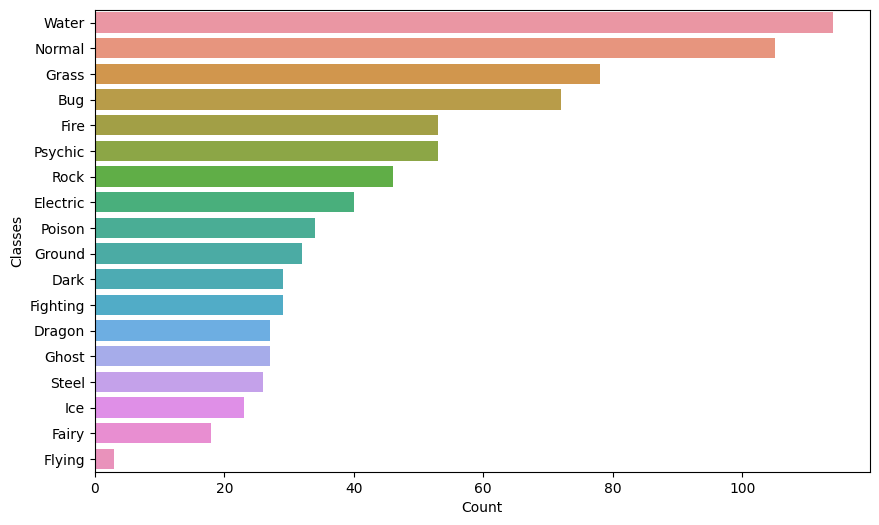

In [ ]:
# Set the figure size for the upcoming plot
plt.figure(figsize=(10, 6))

# Create a bar plot for the counts of unique values in the 'Type1' column
# - Convert the value counts of 'Type1' to a DataFrame
# - Reset the index so that it can be used as a column

sns.barplot(x='Type1', y='index', data=data['Type1'].value_counts().to_frame().reset_index())
plt.xlabel('Count') # Set the x-axis label to 'Count'
plt.ylabel('Classes') # Set the y-axis label to 'Classes'
plt.show() # Display the plot


**Observations**

From the above graph we can notice the wide imbalanced distribution across the 18 classes.

In [ ]:
# Count the occurrences of each unique value in the 'Type1' column
# Convert the resulting Series to a DataFrame and reset the index

data['Type1'].value_counts().to_frame().reset_index()

,index,Type1
0,Water,114
1,Normal,105
2,Grass,78
3,Bug,72
4,Fire,53
5,Psychic,53
6,Rock,46
7,Electric,40
8,Poison,34
9,Ground,32


In [ ]:
len(data) # number of images in the data frame

809

From the above graph and table, we see the high imbalance nature of our data set across 18 distinct classes

In [ ]:
img_dir = '/content/drive/MyDrive/Colab Notebooks' # Initialize the directory path to the 'Colab Notebooks' folder in Google Drive


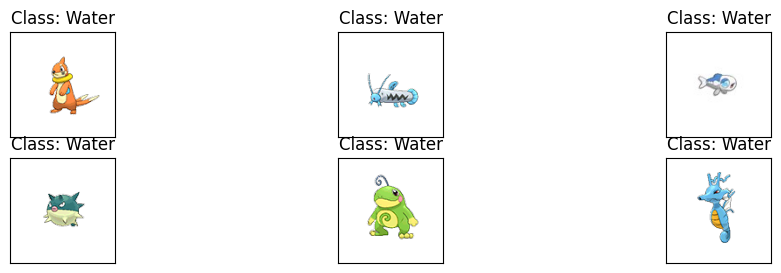

In [ ]:
# Filter the dataset to only include Pokémon with 'Type1' as 'Water'
pokemon = data[data['Type1']=='Water']

# Randomly sample 6 Pokémon from the filtered set
pokemon = pokemon.sample(6)

# Extract the names of the sampled Pokémon
pokemon_name = pokemon['Name'].values

# Extract the types of the sampled Pokémon (which will all be 'Water' in this case)
pokemon_type = pokemon['Type1'].values

# Plot the sampled Pokémon using the extracted names and types
plot(pokemon_name, pokemon_type)

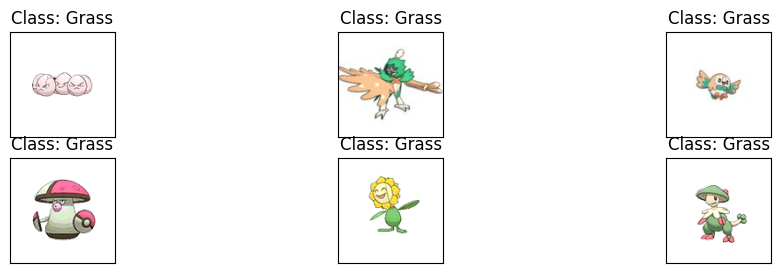

In [ ]:
# Filter the dataset to only include Pokémon with 'Type1' as 'Grass'
pokemon = data[data['Type1']=='Grass']

# Randomly sample 6 Pokémon from the filtered set
pokemon = pokemon.sample(6)

# Extract the names of the sampled Pokémon
pokemon_name = pokemon['Name'].values

# Extract the types of the sampled Pokémon (which will all be 'Water' in this case)
pokemon_type = pokemon['Type1'].values

# Plot the sampled Pokémon using the extracted names and types
plot(pokemon_name, pokemon_type)

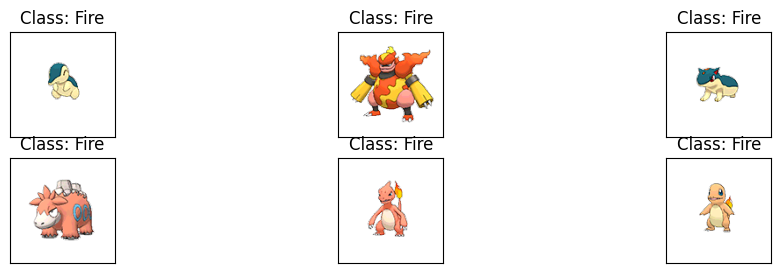

In [ ]:
# Filter the dataset to only include Pokémon with 'Type1' as 'Fire'
pokemon = data[data['Type1']=='Fire']

# Randomly sample 6 Pokémon from the filtered set
pokemon = pokemon.sample(6)

# Extract the names of the sampled Pokémon
pokemon_name = pokemon['Name'].values

# Extract the types of the sampled Pokémon (which will all be 'Water' in this case)
pokemon_type = pokemon['Type1'].values

# Plot the sampled Pokémon using the extracted names and types
plot(pokemon_name, pokemon_type)

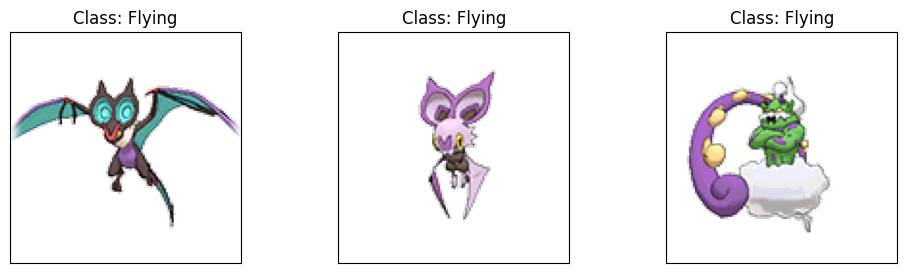

In [ ]:
# Filter the dataset to only include Pokémon with 'Type1' as 'FLying'
pokemon = data[data['Type1']=='Flying']

# Randomly sample 3 Pokémon from the filtered set
pokemon = pokemon.sample(3)

# Extract the names of the sampled Pokémon
pokemon_name = pokemon['Name'].values

# Extract the types of the sampled Pokémon (which will all be 'Water' in this case)
pokemon_type = pokemon['Type1'].values

# Plot the sampled Pokémon using the extracted names and types
plot(pokemon_name, pokemon_type)

In [ ]:
# converting the 'Type1' column in a pandas DataFrame named 'data' to the string data type.
data['Type1'] = data['Type1'].astype('str')

In [ ]:
# creating 3 folds in the DataFrame for cross-validation
data = create_folds(data, 3)
data.head(5)

,Name,Type1,kfold
0,espurr.png,Psychic,0
1,spoink.png,Psychic,0
2,swadloon.png,Bug,0
3,solgaleo.jpg,Psychic,0
4,klefki.png,Steel,0


In [ ]:
# counting the occurrences of each unique fold number in the DataFrame.
data['kfold'].value_counts()

0    270
1    270
2    269
Name: kfold, dtype: int64

In [ ]:
train_dir ='/content/drive/MyDrive/Colab Notebooks/images'

**Model Building - Convolutional Neural Network (CNN)**

Let's create a CNN model sequentially, where we will be adding the layers one after another.

First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow to be able to reproduce the same results every time we run the code.

In [ ]:
# clearing backend
backend.clear_session()

In [ ]:
# fixing the seed for random number generators

import random
np.random.seed(28)
random.seed(28)
tf.random.set_seed(28)

**Now, let's build a CNN Model with the following 2 main parts -**

The Feature Extraction layers which are comprised of convolutional and pooling layers.

The Fully Connected classification layers for prediction.

In [ ]:
model = Sequential() # initializing the sequential model

# Input Layer
model.add(Conv2D(96, (3,3), padding ='same', input_shape = (120, 120, 3), activation = 'relu'))
# Padding is used to maintain the same dimension of features if you set it to same
model.add(MaxPool2D(2,2))

# Hidden layer 1
model.add(Conv2D(64, (3,3), padding ='same',  activation = 'relu'))
model.add(MaxPool2D(2,2))

# Hidden layer 2
model.add(Conv2D(64, (3,3), padding ='same',  activation = 'relu'))
model.add(MaxPool2D(2,2))

# Hidden layer 3
model.add(Conv2D(32, (3,3), padding ='same',  activation = 'relu'))
model.add(MaxPool2D(2,2))

# Flatten
model.add(Flatten())
# Dense
model.add(Dense(100, activation = 'relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
# final layer
model.add(Dense(18, activation='softmax'))

# optimizer
opt = Adam(learning_rate=0.001)

# compile network
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Generate Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 96)      2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        55360     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

-------------------------
0-fold training
-------------------------
Found 539 validated image filenames belonging to 18 classes.
Found 270 validated image filenames belonging to 18 classes.
Setting learning rate to 0.001
Epoch 1/20
34/34 [==============================] - 543s 16s/step - loss: 2.9383 - accuracy: 0.1262 - val_loss: 2.8644 - val_accuracy: 0.1407 - lr: 0.0010
Setting learning rate to 0.001
Epoch 2/20
34/34 [==============================] - 4s 108ms/step - loss: 2.8490 - accuracy: 0.1558 - val_loss: 2.7883 - val_accuracy: 0.1222 - lr: 0.0010
Setting learning rate to 0.001
Epoch 3/20
34/34 [==============================] - 4s 111ms/step - loss: 2.7871 - accuracy: 0.1429 - val_loss: 2.7827 - val_accuracy: 0.1593 - lr: 0.0010
Setting learning rate to 0.001
Epoch 4/20
34/34 [==============================] - 5s 135ms/step - loss: 2.7497 - accuracy: 0.1596 - val_loss: 2.7339 - val_accuracy: 0.1519 - lr: 0.0010
Learning rate: 0.001
Epoch 5/20
34/34 [===========================

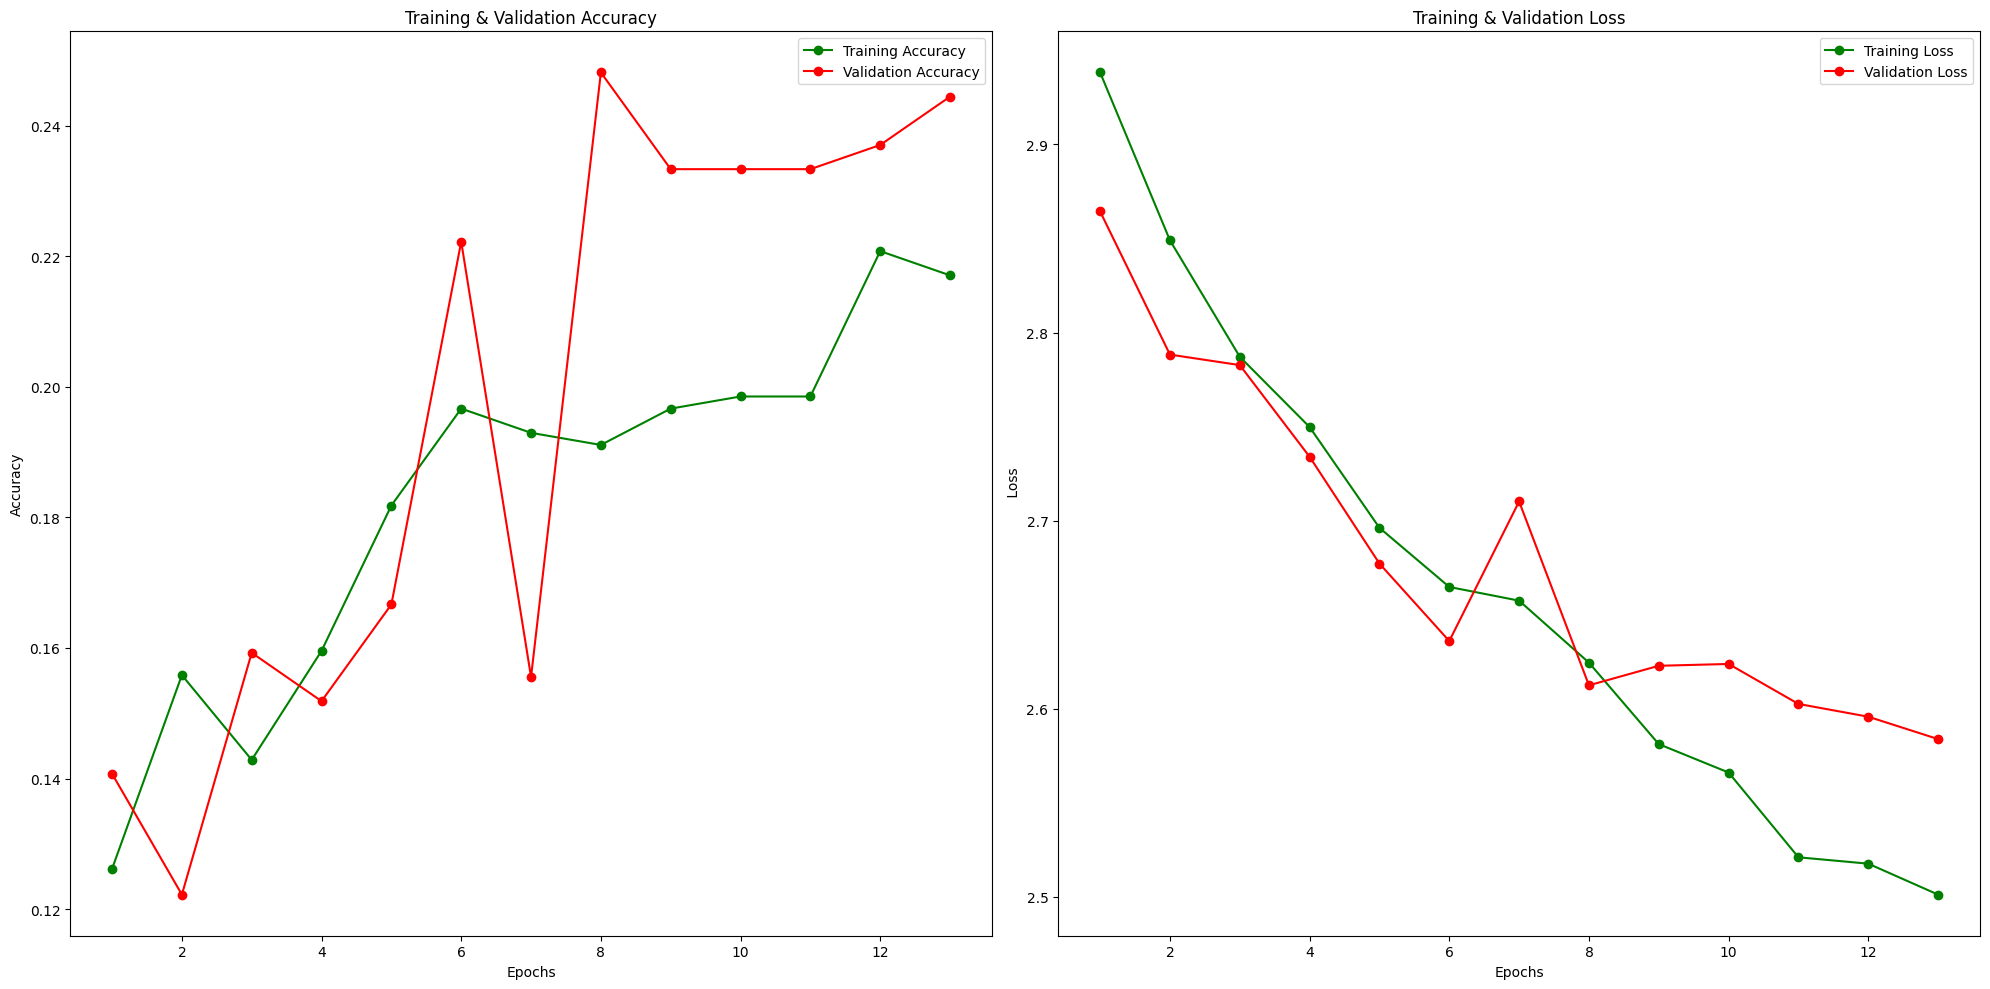

Model computation time: 0:10:07.233988
-------------------------
1-fold training
-------------------------
Found 539 validated image filenames belonging to 18 classes.
Found 270 validated image filenames belonging to 18 classes.
Setting learning rate to 0.001
Epoch 1/20
34/34 [==============================] - 4s 111ms/step - loss: 2.5957 - accuracy: 0.2134 - val_loss: 2.5675 - val_accuracy: 0.2333 - lr: 0.0010
Setting learning rate to 0.001
Epoch 2/20
34/34 [==============================] - 4s 108ms/step - loss: 2.5828 - accuracy: 0.2189 - val_loss: 2.5923 - val_accuracy: 0.2111 - lr: 0.0010
Setting learning rate to 0.001
Epoch 3/20
34/34 [==============================] - 4s 121ms/step - loss: 2.5969 - accuracy: 0.2134 - val_loss: 2.5690 - val_accuracy: 0.2074 - lr: 0.0010
Setting learning rate to 0.001
Epoch 4/20
34/34 [==============================] - 4s 115ms/step - loss: 2.5790 - accuracy: 0.2263 - val_loss: 2.5780 - val_accuracy: 0.2000 - lr: 0.0010
Changing learning rate from

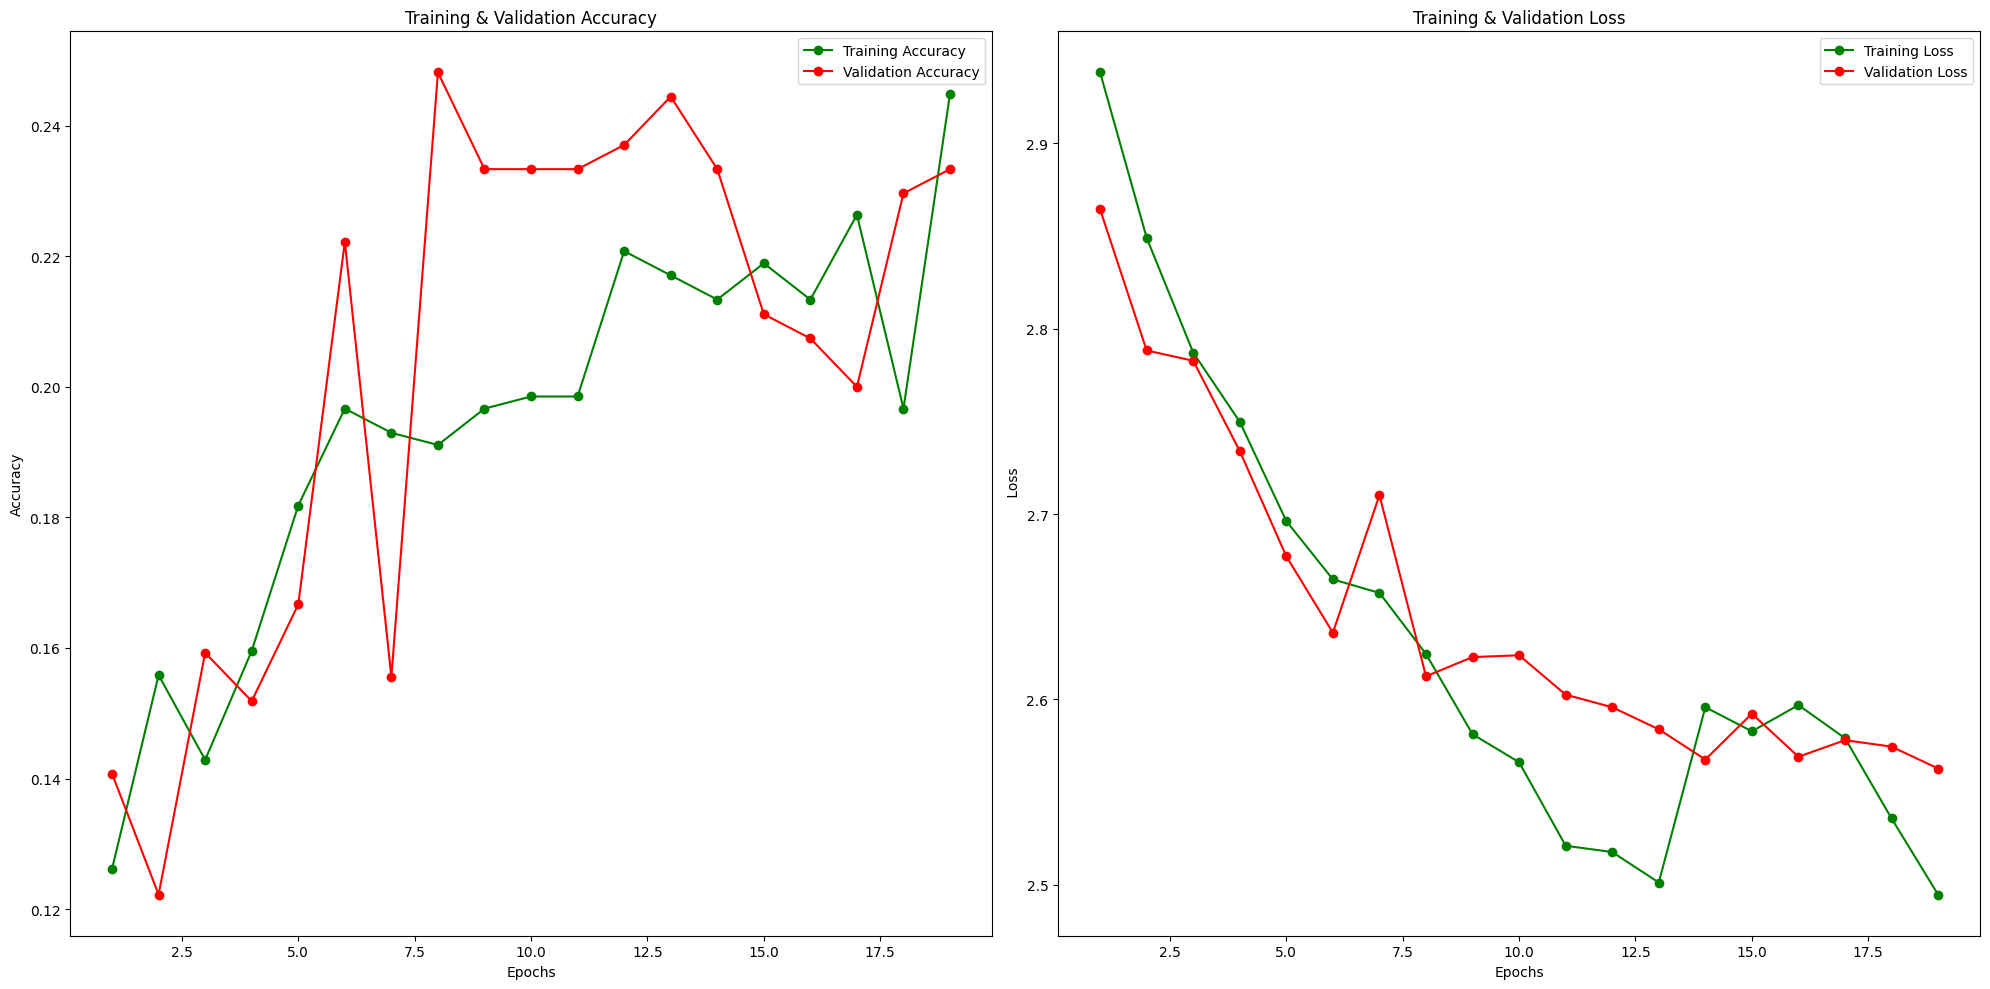

Model computation time: 0:00:26.644897
-------------------------
2-fold training
-------------------------
Found 540 validated image filenames belonging to 18 classes.
Found 269 validated image filenames belonging to 18 classes.
Setting learning rate to 0.001
Epoch 1/20
34/34 [==============================] - 5s 159ms/step - loss: 2.5928 - accuracy: 0.2296 - val_loss: 2.5299 - val_accuracy: 0.2045 - lr: 0.0010
Setting learning rate to 0.001
Epoch 2/20
34/34 [==============================] - 4s 108ms/step - loss: 2.6209 - accuracy: 0.2278 - val_loss: 2.5132 - val_accuracy: 0.2193 - lr: 0.0010
Setting learning rate to 0.001
Epoch 3/20
34/34 [==============================] - 5s 144ms/step - loss: 2.5737 - accuracy: 0.2315 - val_loss: 2.5488 - val_accuracy: 0.2007 - lr: 0.0010
Setting learning rate to 0.001
Epoch 4/20
34/34 [==============================] - 4s 109ms/step - loss: 2.5653 - accuracy: 0.2130 - val_loss: 2.5459 - val_accuracy: 0.2082 - lr: 0.0010
Changing learning rate from

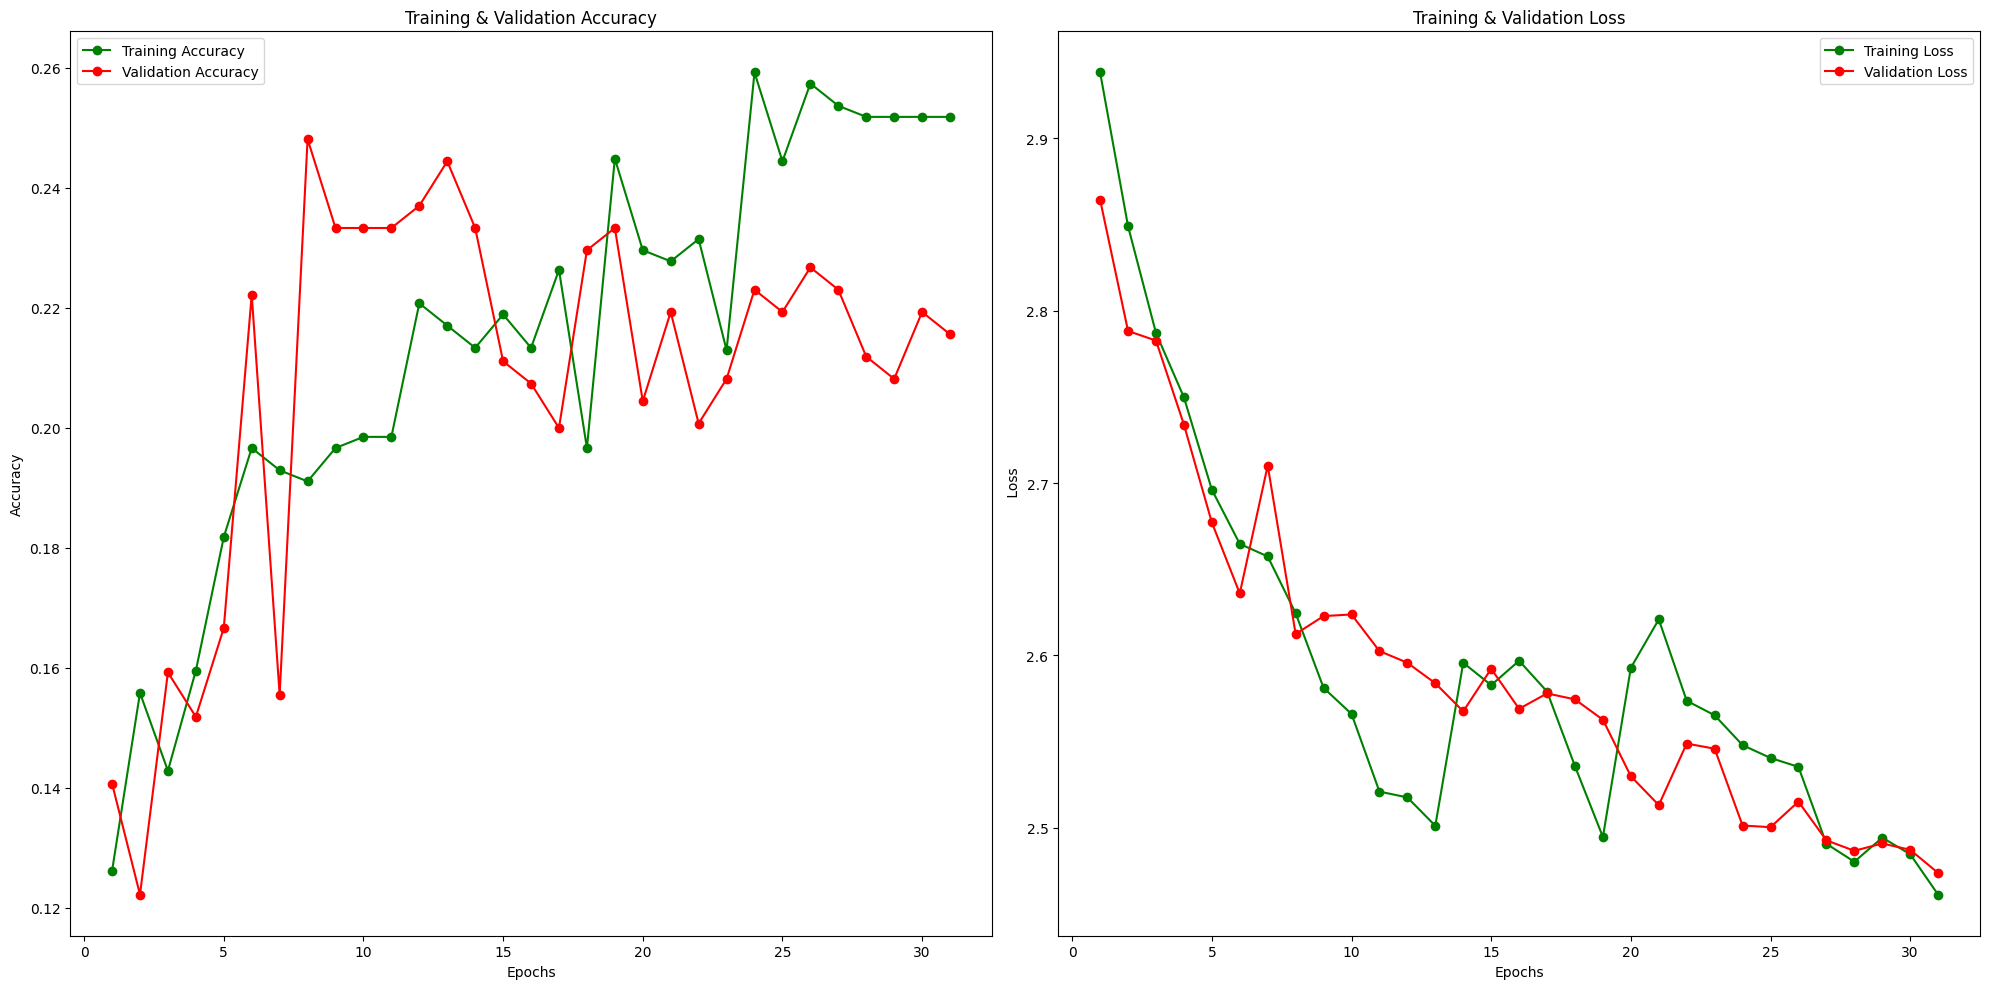

Model computation time: 0:01:03.001678


In [ ]:
# Lists to store out-of-fold (OOF) training and validation metrics for the base model
base_oof_acc=[]
base_oof_val_acc=[]
base_oof_loss=[]
base_oof_val_loss=[]

# List to store computation times for each fold
base_model_time = []

# Loop to perform 3-fold training
for i in range(3):

    # Record the start time of the current fold's training
    t1_1 = datetime.now()

    # Printing the fold number
    print(25*"-")
    print(f'{i}-fold training')
    print(25*"-")

    # Call the train_model function to train the model for the current fold
    # The train_model function seems to take parameters for data, batch size, image dimensions, fold number, and model.
    model, history, train_generator, validation_generator = train_model(data, 16, 120, 120, i, model) #Vary batch_size, img_rows, img_cols

    # Extracting accuracy and loss metrics from the training history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Appending the metrics to the OOF lists
    base_oof_acc.append(train_accuracy)
    base_oof_val_acc.append(val_accuracy)
    base_oof_loss.append(train_loss)
    base_oof_val_loss.append(val_loss)

    # Plotting training & validation accuracy and loss metrics for the current fold
    epochs = range(1, len(train_accuracy) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.set_size_inches(20,10)

    ax1.plot(epochs , train_accuracy , 'go-' , label = 'Training Accuracy')
    ax1.plot(epochs , val_accuracy , 'ro-' , label = 'Validation Accuracy')
    ax1.set_title('Training & Validation Accuracy')
    ax1.legend()
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")

    ax2.plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax2.plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax2.set_title('Training & Validation Loss')
    ax2.legend()
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel(" Loss")

    fig.tight_layout()
    plt.show()

    # Record the end time of the current fold's training and compute the duration
    t2_1 = datetime.now()
    base_model_time.append(str(t2_1 - t1_1))
    print("Model computation time: " + str(t2_1 - t1_1))

In [ ]:
base_acc_average = [sum(sub_list) / len(sub_list) for sub_list in base_oof_acc]
base_val_acc_average = [sum(sub_list) / len(sub_list) for sub_list in base_oof_val_acc]
base_loss_average = [sum(sub_list) / len(sub_list) for sub_list in base_oof_loss]
base_val_loss_average = [sum(sub_list) / len(sub_list) for sub_list in base_oof_val_loss]

In [ ]:
print("Average training accuracy across 3 folds with 20 epochs each -", base_acc_average)
print("Average validation accuracy across 3 folds with 20 epochs each -", base_val_acc_average)
print("Average training loss across 3 folds with 20 epochs each -", base_loss_average)
print("Average validation loss across 3 folds with 20 epochs each -", base_val_loss_average)

Average training accuracy across 3 folds with 20 epochs each - [0.2134224642669001, 0.2134224642669001, 0.2134224642669001]
Average validation accuracy across 3 folds with 20 epochs each - [0.207835117895757, 0.207835117895757, 0.207835117895757]
Average training loss across 3 folds with 20 epochs each - [2.5943990753542994, 2.5943990753542994, 2.5943990753542994]
Average validation loss across 3 folds with 20 epochs each - [2.5923714945393224, 2.5923714945393224, 2.5923714945393224]


In [ ]:
base_model_time

['0:10:07.233988', '0:00:26.644897', '0:01:03.001678']

In [ ]:
base_acc_average = [sum(sub_list) / len(sub_list)
                    for sub_list in base_oof_acc]
base_acc_average

[0.2134224642669001, 0.2134224642669001, 0.2134224642669001]

In [ ]:
print("KFold Validation Accuracy: ", np.hstack(base_oof_acc).mean())

KFold Validation Accuracy:  0.2134224642669001


In [ ]:
# Use the trained model to predict the class labels for the validation set
Y_pred = model.predict_generator(validation_generator)

# Convert the one-hot encoded predictions to class labels
y_pred = np.argmax(Y_pred, axis=1)

# Print the classification report
print('Classification Report')

# Extract the class names from the training generator
target_names = list(train_generator.class_indices.keys()) # Classes

# Generate and print the classification report using true class labels and predicted class labels
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

         Bug       0.29      0.08      0.13        24
        Dark       0.00      0.00      0.00         9
      Dragon       0.00      0.00      0.00         9
    Electric       0.00      0.00      0.00        13
       Fairy       0.00      0.00      0.00         6
    Fighting       0.00      0.00      0.00        10
        Fire       0.38      0.50      0.43        18
      Flying       0.00      0.00      0.00         1
       Ghost       0.00      0.00      0.00         9
       Grass       0.26      0.23      0.24        26
      Ground       0.00      0.00      0.00        11
         Ice       0.00      0.00      0.00         7
      Normal       0.18      0.49      0.27        35
      Poison       0.00      0.00      0.00        12
     Psychic       0.00      0.00      0.00        17
        Rock       0.00      0.00      0.00        15
       Steel       0.00      0.00      0.00         9
     

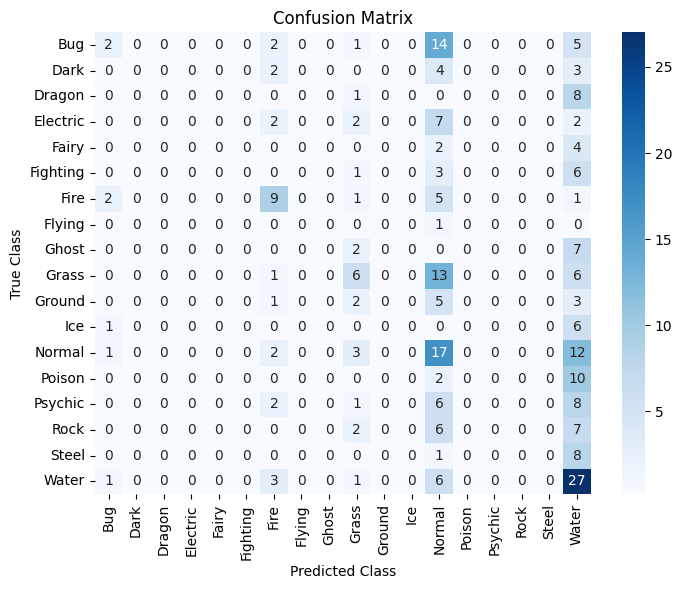

In [ ]:
cm = confusion_matrix(validation_generator.classes, y_pred)
labels = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
       'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
       'Psychic', 'Rock', 'Steel', 'Water']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

1/1 [==============================] - 0s 20ms/step


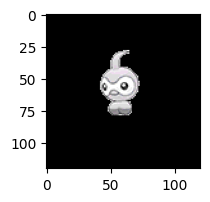

Predicted Class: Normal
True Class: Normal


In [ ]:
# class names in the correct order
class_names = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
               'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
               'Psychic', 'Rock', 'Steel', 'Water']

# Function to visualize predictions
def visualize_prediction(image, predicted_label, true_label):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.show()

    # Get the index of the predicted class (class with the highest probability)
    predicted_class_index = np.argmax(predicted_label)

    # Get the index of the true class (class with value 1 in the one-hot encoded array)
    true_class_index = np.argmax(true_label)

    # Get the predicted and true class names
    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    print('Predicted Class:', predicted_class_name)
    print('True Class:', true_class_name)

# Assuming validation_generator is your validation data generator
index_to_visualize = 4

# Fetch the test image and true label from the validation_generator
for i, (X_val_batch, y_val_batch) in enumerate(validation_generator):
    if i == index_to_visualize:
        test_image = X_val_batch[0]  # Assuming batch size is 1
        true_label = y_val_batch[0]  # Assuming batch size is 1
        break

# Normalize the test image (if needed)
test_image_normalized = test_image / 255.0

# Get the model's prediction for the test image
predicted_label = model.predict(test_image_normalized.reshape(1, 120, 120, 3))

# Visualize the test image and its predicted class
visualize_prediction(test_image, predicted_label, true_label)


1/1 [==============================] - 0s 21ms/step


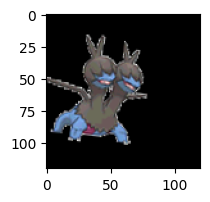

Predicted Class: Normal
True Class: Dark


In [ ]:
# class names in the correct order
class_names = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
               'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
               'Psychic', 'Rock', 'Steel', 'Water']

# Function to visualize predictions
def visualize_prediction(image, predicted_label, true_label):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.show()

    # Get the index of the predicted class (class with the highest probability)
    predicted_class_index = np.argmax(predicted_label)

    # Get the index of the true class (class with value 1 in the one-hot encoded array)
    true_class_index = np.argmax(true_label)

    # Get the predicted and true class names
    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    print('Predicted Class:', predicted_class_name)
    print('True Class:', true_class_name)

#validation data generator
index_to_visualize = 100

# Fetch the test image and true label from the validation_generator
for i, (X_val_batch, y_val_batch) in enumerate(validation_generator):
    if i == index_to_visualize:
        test_image = X_val_batch[10]  # Assuming batch size is 1
        true_label = y_val_batch[10]  # Assuming batch size is 1
        break

# Normalize the test image (if needed)
test_image_normalized = test_image / 255.0

# Get the model's prediction for the test image
predicted_label = model.predict(test_image_normalized.reshape(1, 120, 120, 3))

# Visualize the test image and its predicted class
visualize_prediction(test_image, predicted_label, true_label)


1/1 [==============================] - 0s 34ms/step


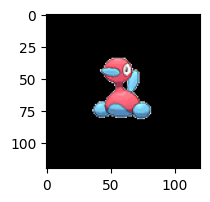

Predicted Class: Normal
True Class: Normal


In [ ]:
#list of class names in the correct order
class_names = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
               'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
               'Psychic', 'Rock', 'Steel', 'Water']

# Function to visualize predictions
def visualize_prediction(image, predicted_label, true_label):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.show()

    # Get the index of the predicted class (class with the highest probability)
    predicted_class_index = np.argmax(predicted_label)

    # Get the index of the true class (class with value 1 in the one-hot encoded array)
    true_class_index = np.argmax(true_label)

    # Get the predicted and true class names
    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    print('Predicted Class:', predicted_class_name)
    print('True Class:', true_class_name)

# validation data generator
index_to_visualize = 3

# Fetch the test image and true label from the validation_generator
for i, (X_val_batch, y_val_batch) in enumerate(validation_generator):
    if i == index_to_visualize:
        test_image = X_val_batch[0]  # Assuming batch size is 1
        true_label = y_val_batch[0]  # Assuming batch size is 1
        break

# Normalize the test image (if needed)
test_image_normalized = test_image / 255.0

# Get the model's prediction for the test image
predicted_label = model.predict(test_image_normalized.reshape(1, 120, 120, 3))

# Visualize the test image and its predicted class
visualize_prediction(test_image, predicted_label, true_label)


**Working with the two highest classes to see the performance of our model (Water and Normal)**

In [ ]:
# Reading the Normal and Water classes into the data frame
data1 = pd.read_csv('pokemon_file4.csv')

In [ ]:
# shuffle the dataframe
data1 = data1.sample(frac=1).reset_index(drop=True)

In [ ]:
data1['Type1'].value_counts().to_frame().reset_index()

,index,Type1
0,Water,114
1,Normal,105


In [ ]:
np.round((data1['Type1'].value_counts() / len(data1['Type1'])) * 100, 2)

Water     52.05
Normal    47.95
Name: Type1, dtype: float64

In [ ]:
len(data1)

219

In [ ]:
# Define the directory path to the training images
train_dir ='/content/drive/MyDrive/Colab Notebooks/images4'

# Define the data_generator function
def data_generator(train, validation , batch_size, img_rows, img_cols):

       # Initialize the ImageDataGenerator for training data with specified augmentations
        train_datagen = ImageDataGenerator(rescale=1./225,
                           rotation_range=360)

        # Initialize the ImageDataGenerator for validation data without augmentations but with rescaling
        validation_datagen = ImageDataGenerator(rescale=1./255,)

        # Create the data generator for the training set
        train_gen = train_datagen.flow_from_dataframe(train,
                                                    train_dir,
                                                    x_col = 'Name',
                                                    y_col = 'Type1',
                                                    target_size=(img_rows, img_cols),
                                                    seed = 28,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    interpolation = 'nearest',
                                                    shuffle=True)

        # Create the data generator for the validation set
        validation_gen = validation_datagen.flow_from_dataframe(validation,
                                                    train_dir,
                                                    x_col = 'Name',
                                                    y_col = 'Type1',
                                                    target_size=(img_rows, img_cols),
                                                    seed = 28,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    interpolation = 'nearest',
                                                    shuffle=False)

        # Return the training and validation data generators
        return train_gen, validation_gen

**Model Building - Convolutional Neural Network (CNN)**

In [ ]:
# clearing backend
backend.clear_session()

In [ ]:
# fixing the seed for random number generators

import random
np.random.seed(28)
random.seed(28)
tf.random.set_seed(28)

In [ ]:
class LossLearningRateScheduler(tf.keras.callbacks.History):
    """
    base_lr: the starting learning rate
    lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    spike_multiple: the multiple applied to the current learning rate for a spike.
    """

    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10, decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):
        super(LossLearningRateScheduler, self).__init__()
        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):

        # If more than `lookback_epochs` have passed

        if len(self.epoch) > self.lookback_epochs:
            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            target_loss = self.history[self.loss_type]
            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]

            # Check if the difference in loss is below the threshold

            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):
                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple
            else:
                print(' '.join(('Learning rate:', str(current_lr))))

            # Spike learning rate if the current epoch is in the `spike_epochs` list

            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)
        else:
          # For the initial epochs up to `lookback_epochs`, set learning rate to `base_lr`

            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

        return tf.keras.backend.get_value(self.model.optimizer.lr)



callback_lr = LossLearningRateScheduler(base_lr=0.001, lookback_epochs=3)

In [ ]:
model_1 = Sequential() # initializing the sequential model

# Input Layer
model_1.add(Conv2D(96, (3,3), padding ='same', input_shape = (120, 120, 3), activation = 'relu'))
# Padding is used to maintain the same dimension of features if you set it to same
model_1.add(MaxPool2D(2,2))

# Hidden layer 1
model_1.add(Conv2D(64, (3,3), padding ='same',  activation = 'relu'))
model_1.add(MaxPool2D(2,2))

# Hidden layer 2
model_1.add(Conv2D(64, (3,3), padding ='same',  activation = 'relu'))
model_1.add(MaxPool2D(2,2))

# Hidden layer 3
model_1.add(Conv2D(32, (3,3), padding ='same',  activation = 'relu'))
model_1.add(MaxPool2D(2,2))

# Flatten
model_1.add(Flatten())
# Dense
model_1.add(Dense(100, activation = 'relu', kernel_regularizer=l2(0.001)))
model_1.add(Dropout(0.2))
# final layer
model_1.add(Dense(2, activation='sigmoid'))

# optimizer
opt = Adam(learning_rate=0.001)

# compile network
model_1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Generate Model Summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 96)      2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        55360     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

In [ ]:
# Function for training
def train_model(df, batch_size, img_rows, img_cols, model):

    # Record the start time of the training process
    t1_1 = datetime.now()

    # Reset the index of the dataframe for both training and validation sets.
    # In this case, the same dataframe 'df' is being used for both training and validation (possibly not ideal in a real-world scenario).
    train = df.reset_index(drop=True)
    validation = df.reset_index(drop=True)

    # Generate the training and validation data generators using the data_generator function
    train_generator, validation_generator = data_generator(train, validation, batch_size, img_rows, img_cols)

    # Create a list of callbacks for the training process:
    # 1. EarlyStopping: Stop training when 'val_accuracy' stops improving after 5 epochs.
    # 2. ReduceLROnPlateau: Reduce learning rate when 'val_loss' stops improving.
    # 3. callback_lr: This callback isn't defined in the given code, but it's presumably related to learning rate adjustments.
    callback_list = [callbacks.EarlyStopping(monitor='val_accuracy',patience=5, mode='max', restore_best_weights=True),
                    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min'), callback_lr]

    # Train the model using the generated data generators and the specified callbacks for 20 epochs.
    # class_weight parameter is commented out but can be useful if dealing with imbalanced datasets.
    history = model.fit(train_generator, validation_data=validation_generator, callbacks=callback_list, epochs=20) #class_weight=class_weights)

    # Return the trained model, its training history, and the training and validation data generators
    return model, history, train_generator, validation_generator

Found 219 validated image filenames belonging to 2 classes.
Found 219 validated image filenames belonging to 2 classes.
Setting learning rate to 0.001
Epoch 1/20
14/14 [==============================] - 5s 149ms/step - loss: 0.8617 - accuracy: 0.4521 - val_loss: 0.8202 - val_accuracy: 0.5205 - lr: 0.0010
Setting learning rate to 0.001
Epoch 2/20
14/14 [==============================] - 2s 138ms/step - loss: 0.8034 - accuracy: 0.5068 - val_loss: 0.7689 - val_accuracy: 0.5205 - lr: 0.0010
Setting learning rate to 0.001
Epoch 3/20
14/14 [==============================] - 2s 118ms/step - loss: 0.7267 - accuracy: 0.5388 - val_loss: 0.6578 - val_accuracy: 0.6438 - lr: 0.0010
Setting learning rate to 0.001
Epoch 4/20
14/14 [==============================] - 2s 123ms/step - loss: 0.6708 - accuracy: 0.6804 - val_loss: 0.6912 - val_accuracy: 0.6256 - lr: 0.0010
Learning rate: 0.001
Epoch 5/20
14/14 [==============================] - 2s 136ms/step - loss: 0.6746 - accuracy: 0.7032 - val_loss: 0.6

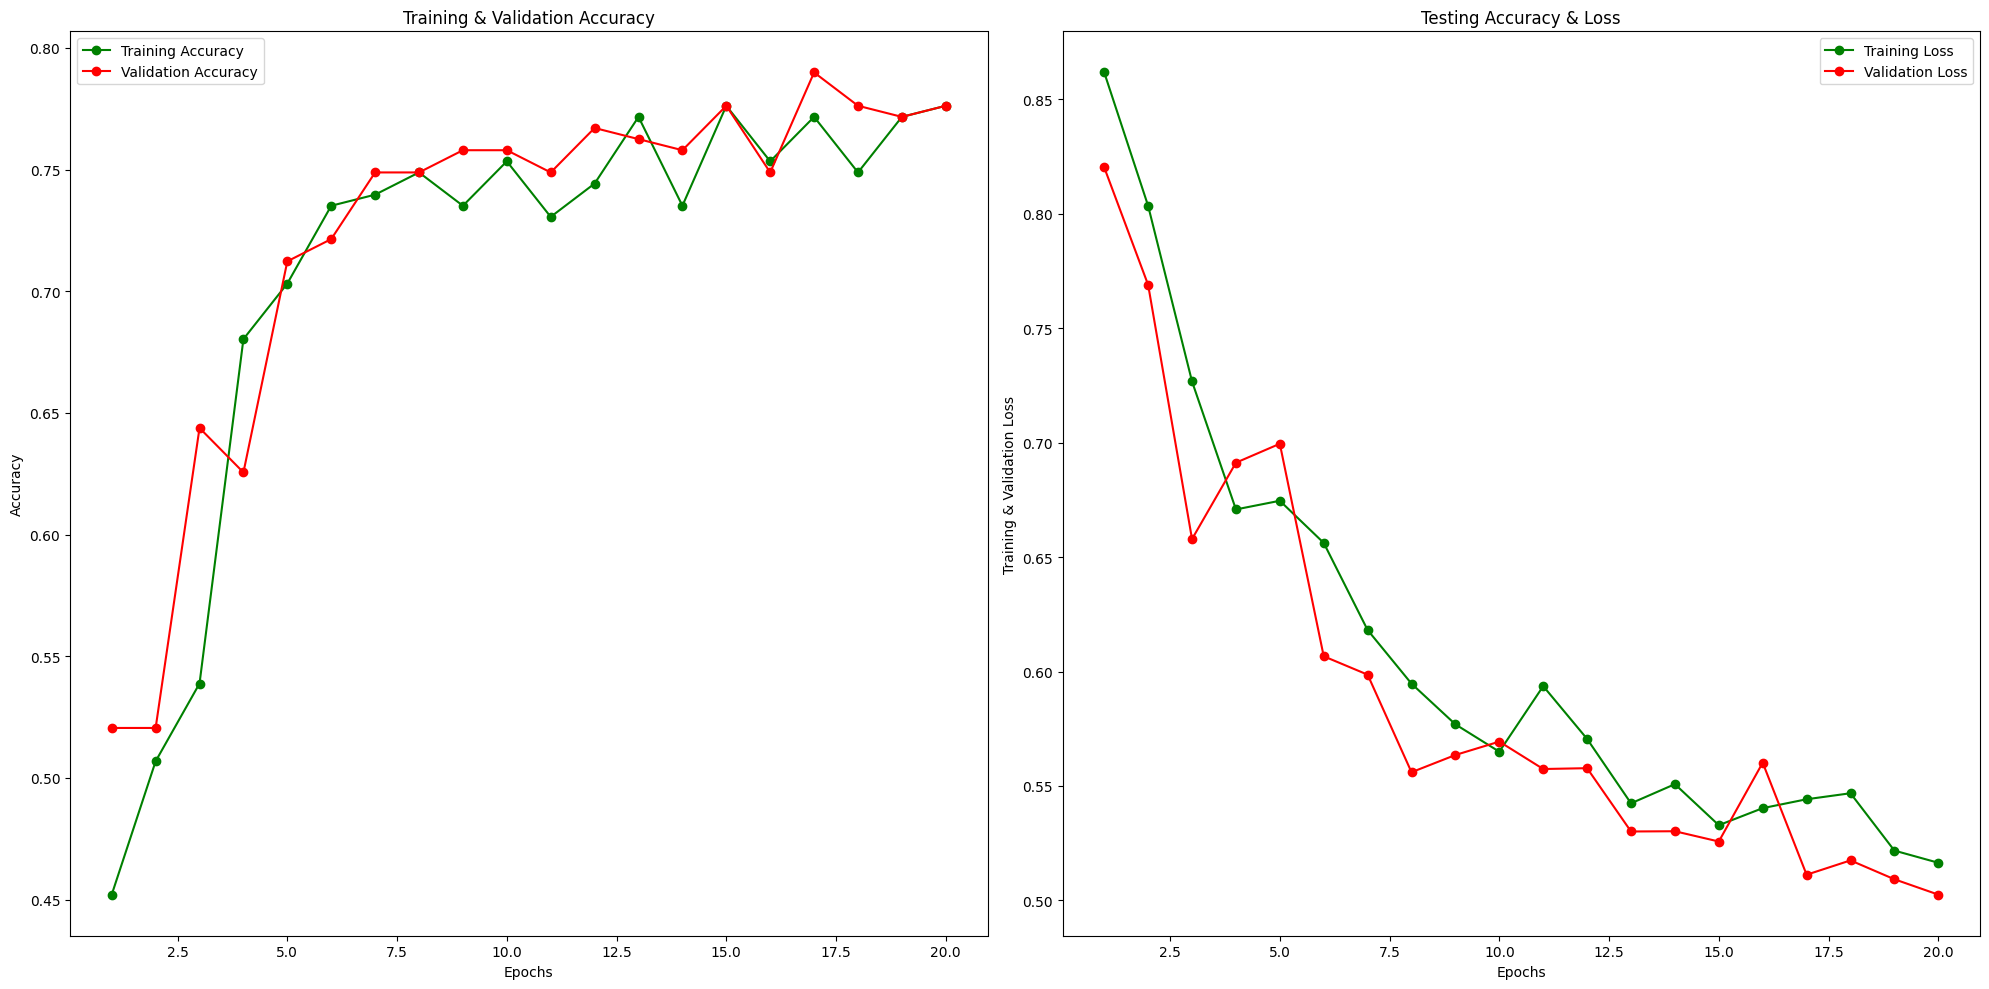

Model computation time: 0:00:45.455439


In [ ]:
# Lists to store the training metrics
base_oof_acc_1=[]
base_oof_val_acc_1=[]
base_oof_loss_1=[]
base_oof_val_loss_1=[]
base_model_time_1 = []


# Record the start time of the training process
t1_1 = datetime.now()

# Train the model using the specified parameters
model_1, history, train_generator, validation_generator = train_model(data1, 16, 120, 120, model_1) #Vary batch_size, img_rows, img_cols

# Extract accuracy and loss metrics for both training and validation sets from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Store the metrics in the corresponding lists
base_oof_acc_1.append(train_accuracy)
base_oof_val_acc_1.append(val_accuracy)
base_oof_loss_1.append(train_loss)
base_oof_val_loss_1.append(val_loss)

# Define the epochs range for plotting
epochs = range(1, len(train_accuracy) + 1)

# Set up a subplot figure to plot both accuracy and loss side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.set_size_inches(20,10)

# Plot training and validation accuracy on the first subplot
ax1.plot(epochs , train_accuracy , 'go-' , label = 'Training Accuracy')
ax1.plot(epochs , val_accuracy , 'ro-' , label = 'Validation Accuracy')
ax1.set_title('Training & Validation Accuracy')
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")

# Plot training and validation loss on the second subplot
ax2.plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax2.plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax2.set_title('Testing Accuracy & Loss')
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Training & Validation Loss")

# Adjust layout and display the plots
fig.tight_layout()
plt.show()

# Record the end time of the training process
t2_1 = datetime.now()

# Calculate and print the time taken for training
base_model_time_1.append(str(t2_1 - t1_1))
print("Model computation time: " + str(t2_1 - t1_1))

In [ ]:
base_acc_average_1 = [sum(sub_list) / len(sub_list) for sub_list in base_oof_acc_1]
base_val_acc_average_1 = [sum(sub_list) / len(sub_list) for sub_list in base_oof_val_acc_1]
base_loss_average_1 = [sum(sub_list) / len(sub_list) for sub_list in base_oof_loss_1]
base_val_loss_average_1 = [sum(sub_list) / len(sub_list) for sub_list in base_oof_val_loss_1]

In [ ]:
print("Average training accuracy across 20 epochs  -", base_acc_average_1)
print("Average validation accuracy across 20 epochs  -", base_val_acc_average_1)
print("Average training loss across 20 epochs  -", base_loss_average_1)
print("Average validation loss across 20 epochs  -", base_val_loss_average_1)

Average training accuracy across 20 epochs  - [0.7086757957935333]
Average validation accuracy across 20 epochs  - [0.7216895043849945]
Average training loss across 20 epochs  - [0.6103905022144318]
Average validation loss across 20 epochs  - [0.5916895806789398]


In [ ]:
base_model_time_1

['0:00:45.455439']

In [ ]:
Y_pred = model_1.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = list(train_generator.class_indices.keys()) # Classes
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Normal       0.71      0.90      0.79       105
       Water       0.88      0.66      0.75       114

    accuracy                           0.78       219
   macro avg       0.80      0.78      0.77       219
weighted avg       0.80      0.78      0.77       219



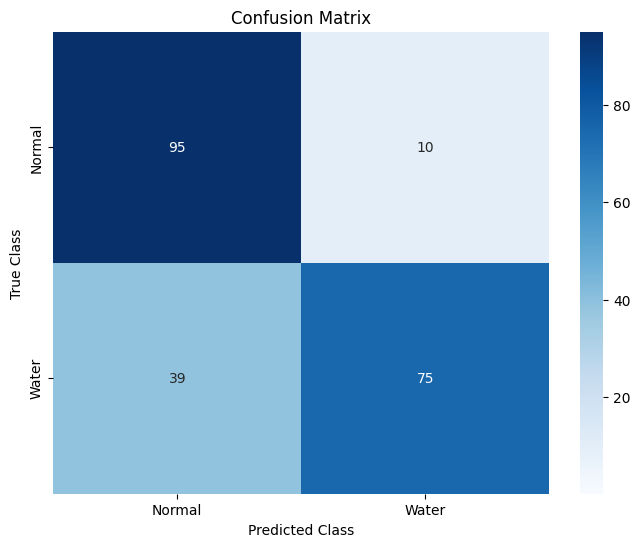

In [ ]:
cm = confusion_matrix(validation_generator.classes, y_pred)
labels = [   'Normal',  'Water']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

**Making Predictions**

1/1 [==============================] - 0s 86ms/step


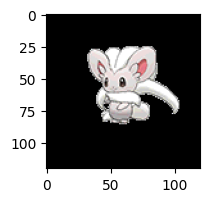

Predicted Class: Normal
True Class: Normal


In [ ]:
#list of class names in the correct order
class_names = ['Normal','Water']

# Function to visualize predictions
def visualize_prediction(image, predicted_label, true_label):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.show()

    # Get the index of the predicted class (class with the highest probability)
    predicted_class_index = np.argmax(predicted_label)

    # Get the index of the true class (class with value 1 in the one-hot encoded array)
    true_class_index = np.argmax(true_label)

    # Get the predicted and true class names
    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    print('Predicted Class:', predicted_class_name)
    print('True Class:', true_class_name)

# validation data generator
index_to_visualize = 4

# Fetch the test image and true label from the validation_generator
for i, (X_val_batch, y_val_batch) in enumerate(validation_generator):
    if i == index_to_visualize:
        test_image = X_val_batch[0]  # Assuming batch size is 1
        true_label = y_val_batch[0]  # Assuming batch size is 1
        break

# Normalize the test image (if needed)
test_image_normalized = test_image / 255.0

# Get the model's prediction for the test image
predicted_label = model_1.predict(test_image_normalized.reshape(1, 120, 120, 3))

# Visualize the test image and its predicted class
visualize_prediction(test_image, predicted_label, true_label)


1/1 [==============================] - 0s 22ms/step


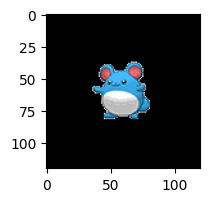

Predicted Class: Normal
True Class: Water


In [ ]:
# list of class names in the correct order
class_names = ['Normal','Water']

# Function to visualize predictions
def visualize_prediction(image, predicted_label, true_label):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.show()

    # Get the index of the predicted class (class with the highest probability)
    predicted_class_index = np.argmax(predicted_label)

    # Get the index of the true class (class with value 1 in the one-hot encoded array)
    true_class_index = np.argmax(true_label)

    # Get the predicted and true class names
    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    print('Predicted Class:', predicted_class_name)
    print('True Class:', true_class_name)

#  validation data generator
index_to_visualize = 4

# Fetch the test image and true label from the validation_generator
for i, (X_val_batch, y_val_batch) in enumerate(validation_generator):
    if i == index_to_visualize:
        test_image = X_val_batch[0]  # Assuming batch size is 1
        true_label = y_val_batch[0]  # Assuming batch size is 1
        break

# Normalize the test image (if needed)
test_image_normalized = test_image / 255.0

# Get the model's prediction for the test image
predicted_label = model_1.predict(test_image_normalized.reshape(1, 120, 120, 3))

# Visualize the test image and its predicted class
visualize_prediction(test_image, predicted_label, true_label)


**The code below was used to generate images from the original dataset and save in a folder in our directory**

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/images'


datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


# img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
img = load_imgimg = load_img(os.path.join(data_dir,"blissey.png"))
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)


# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='/content/drive/MyDrive/Colab Notebooks/aug_images/aug_normal',
                          save_prefix='blissey', save_format='png'):
    i += 1
    if i > 0:
        break  # otherwise the generator would loop indefinitely

**Applying the saved images gotten through data augmentation to increase the images in the dataset**

In [ ]:
# Reading the Normal and Water classes into the data frame
data2 = pd.read_csv('pokemon_file2.csv')
data2 = data2.drop("Type2", axis=1)

In [ ]:
# shuffle the dataframe
data2 = data2.sample(frac=1).reset_index(drop=True)

In [ ]:
data2['Type1'].value_counts().to_frame().reset_index()

,index,Type1
0,Ghost,118
1,Steel,117
2,Dragon,117
3,Dark,114
4,Grass,114
5,Normal,114
6,Electric,114
7,Rock,114
8,Water,114
9,Bug,114


In [ ]:
data2['Type1'] = data2['Type1'].astype('str')

In [ ]:
data2 = create_folds(data2, 3)
data2.head(5)

,Name,Type1,kfold
0,gogoat.png,Grass,0
1,drifloon_0_2871.png,Ghost,0
2,horsea.png,Water,0
3,noivern_0_1988.png,Flying,0
4,dugtrio_0_6563.png,Ground,0


In [ ]:
data2['kfold'].value_counts()

0    676
1    676
2    676
Name: kfold, dtype: int64

In [ ]:
len(data2)

2028

In [ ]:
train_dir ='/content/drive/MyDrive/Colab Notebooks/images2'

def data_generator(train, validation , batch_size, img_rows, img_cols):

        train_datagen = ImageDataGenerator(rescale=1./225,
                           rotation_range=360)

        validation_datagen = ImageDataGenerator(rescale=1./255,)

        train_gen = train_datagen.flow_from_dataframe(train,
                                                    train_dir,
                                                    x_col = 'Name',
                                                    y_col = 'Type1',
                                                    target_size=(img_rows, img_cols),
                                                    seed = 28,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    interpolation = 'nearest',
                                                    shuffle=True)

        validation_gen = validation_datagen.flow_from_dataframe(validation,
                                                    train_dir,
                                                    x_col = 'Name',
                                                    y_col = 'Type1',
                                                    target_size=(img_rows, img_cols),
                                                    seed = 28,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    interpolation = 'nearest',
                                                    shuffle=False)

        return train_gen, validation_gen

**Model Building - Convolutional Neural Network (CNN)**

In [ ]:
# clearing backend
backend.clear_session()

In [ ]:
# fixing the seed for random number generators

import random
np.random.seed(28)
random.seed(28)
tf.random.set_seed(28)

In [ ]:
class LossLearningRateScheduler(tf.keras.callbacks.History):
    """
    base_lr: the starting learning rate
    lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    spike_multiple: the multiple applied to the current learning rate for a spike.
    """

    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10, decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):
        super(LossLearningRateScheduler, self).__init__()
        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):

        # If more than `lookback_epochs` have passed

        if len(self.epoch) > self.lookback_epochs:
            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            target_loss = self.history[self.loss_type]
            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]

            # Check if the difference in loss is below the threshold

            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):
                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple
            else:
                print(' '.join(('Learning rate:', str(current_lr))))

            # Spike learning rate if the current epoch is in the `spike_epochs` list

            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)
        else:
          # For the initial epochs up to `lookback_epochs`, set learning rate to `base_lr`

            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

        return tf.keras.backend.get_value(self.model.optimizer.lr)



callback_lr = LossLearningRateScheduler(base_lr=0.001, lookback_epochs=3)

In [ ]:
model_2 = Sequential() # initializing the sequential model

# Input Layer
model_2.add(Conv2D(96, (3,3), padding ='same', input_shape = (120, 120, 3), activation = 'relu'))
# Padding is used to maintain the same dimension of features if you set it to same
model_2.add(MaxPool2D(2,2))

# Hidden layer 1
model_2.add(Conv2D(64, (3,3), padding ='same',  activation = 'relu'))
model_2.add(MaxPool2D(2,2))

# Hidden layer 2
model_2.add(Conv2D(64, (3,3), padding ='same',  activation = 'relu'))
model_2.add(MaxPool2D(2,2))

# Hidden layer 3
model_2.add(Conv2D(32, (3,3), padding ='same',  activation = 'relu'))
model_2.add(MaxPool2D(2,2))

# Flatten
model_2.add(Flatten())
# Dense
model_2.add(Dense(100, activation = 'relu', kernel_regularizer=l2(0.001)))
model_2.add(Dropout(0.2))
# final layer
model_2.add(Dense(18, activation='softmax'))

# optimizer
opt = Adam(learning_rate=0.001)

# compile network
model_2.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Generate Model Summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 96)      2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        55360     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

In [ ]:
# Function to train a given model on a specific fold of data

def train_model(df, batch_size, img_rows, img_cols, fold, model):

    # Capture the current time to later calculate the training time

    t1_1 = datetime.now()

    # Split the dataframe into training and validation sets based on the provided fold number

    train = df[df.kfold != fold].reset_index(drop=True)
    validation = df[df.kfold == fold].reset_index(drop=True)

    # Generate training and validation data using the data_generator function

    train_generator, validation_generator = data_generator(train, validation, batch_size, img_rows, img_cols)

    # Define the list of callbacks to be used during training

    callback_list = [callbacks.EarlyStopping(monitor='val_accuracy',patience=5, mode='max', restore_best_weights=True),
                    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min'), callback_lr]

    # Train the model using the generators and callbacks
    # Note: The commented parameter `class_weight` could be used if you have uneven class distributions and have computed class weights

    history = model.fit(train_generator, validation_data=validation_generator, callbacks=callback_list, epochs=20) #class_weight=class_weights)

    # Return the trained model, its training history, and the generators for potential further use

    return model, history, train_generator, validation_generator

-------------------------
0-fold training
-------------------------
Found 1352 validated image filenames belonging to 18 classes.
Found 676 validated image filenames belonging to 18 classes.
Setting learning rate to 0.001
Epoch 1/20
85/85 [==============================] - 423s 5s/step - loss: 3.0077 - accuracy: 0.0525 - val_loss: 2.9587 - val_accuracy: 0.0636 - lr: 0.0010
Setting learning rate to 0.001
Epoch 2/20
85/85 [==============================] - 11s 124ms/step - loss: 2.9411 - accuracy: 0.0673 - val_loss: 2.9296 - val_accuracy: 0.0592 - lr: 0.0010
Setting learning rate to 0.001
Epoch 3/20
85/85 [==============================] - 9s 105ms/step - loss: 2.9198 - accuracy: 0.0747 - val_loss: 2.9112 - val_accuracy: 0.0754 - lr: 0.0010
Setting learning rate to 0.001
Epoch 4/20
85/85 [==============================] - 11s 125ms/step - loss: 2.8963 - accuracy: 0.0814 - val_loss: 2.8806 - val_accuracy: 0.0976 - lr: 0.0010
Learning rate: 0.001
Epoch 5/20
85/85 [=========================

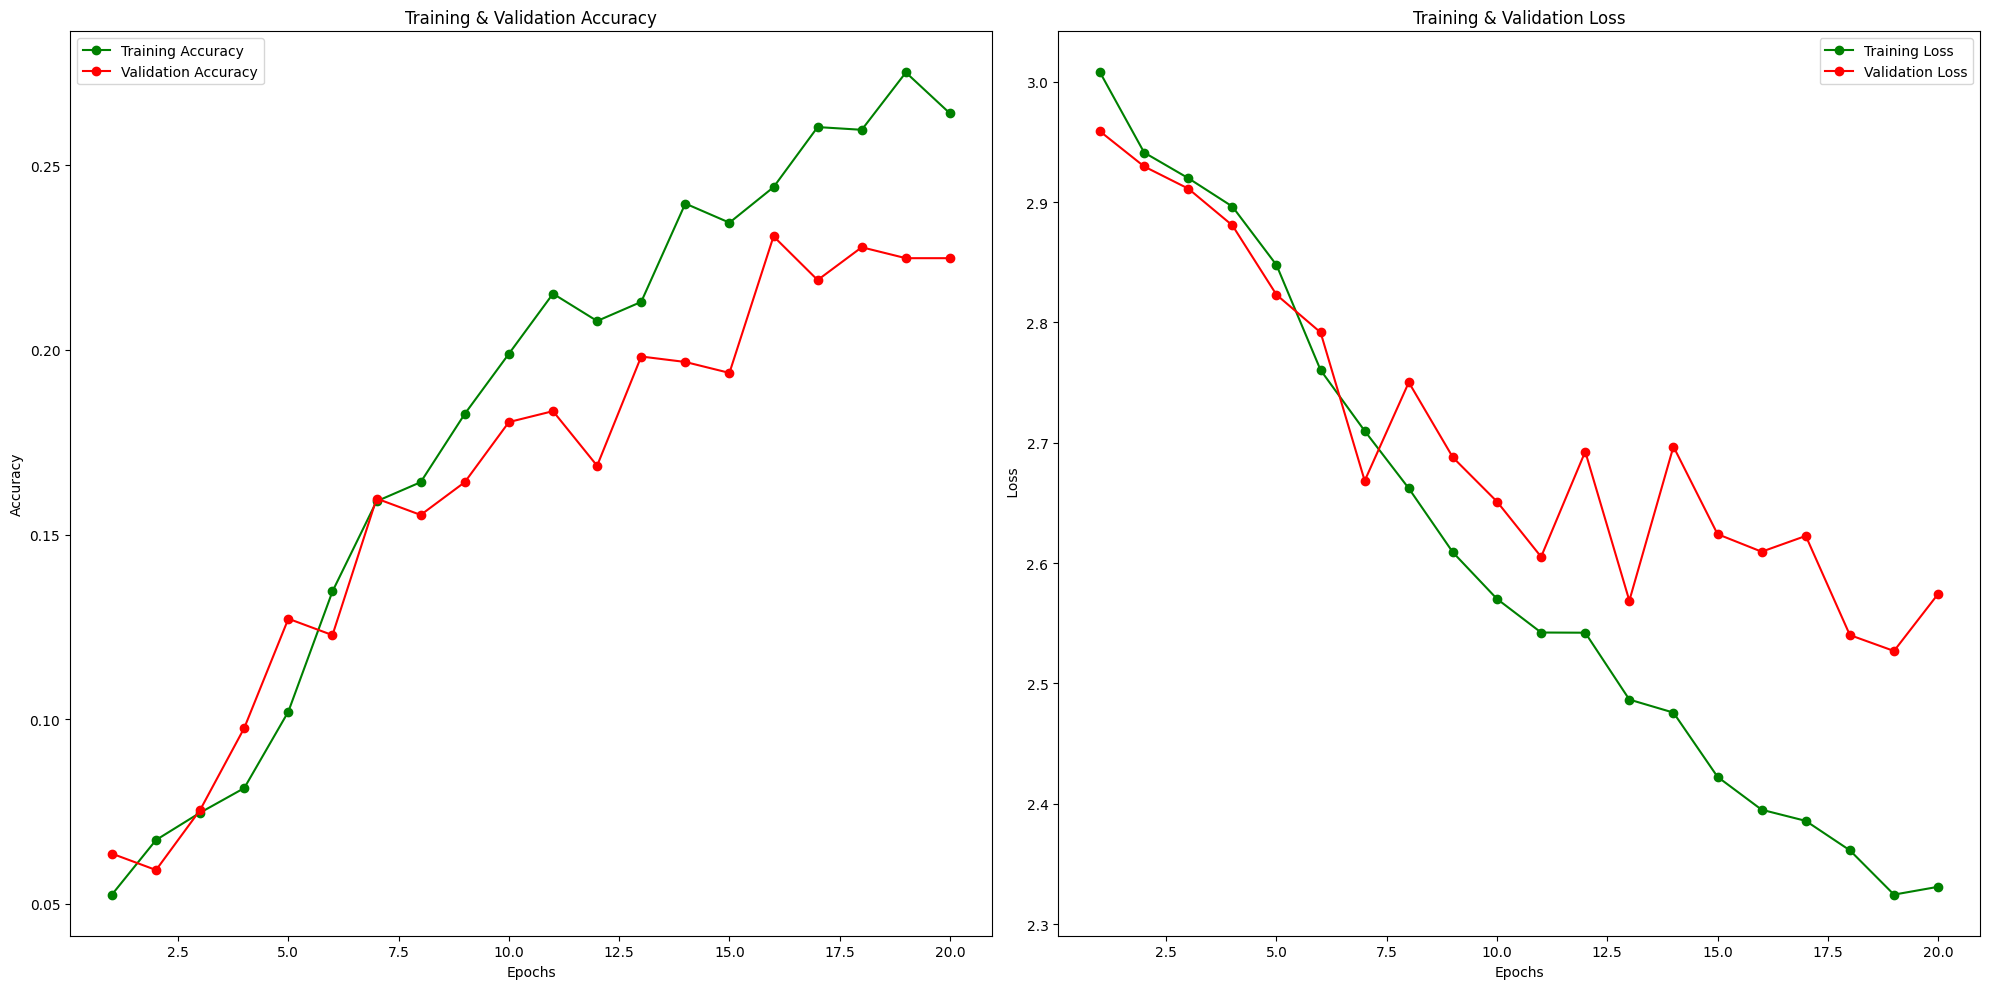

Model computation time: 0:11:09.221247
-------------------------
1-fold training
-------------------------
Found 1352 validated image filenames belonging to 18 classes.
Found 676 validated image filenames belonging to 18 classes.
Setting learning rate to 0.001
Epoch 1/20
85/85 [==============================] - 10s 122ms/step - loss: 2.4843 - accuracy: 0.2359 - val_loss: 2.7010 - val_accuracy: 0.2189 - lr: 0.0010
Setting learning rate to 0.001
Epoch 2/20
85/85 [==============================] - 9s 105ms/step - loss: 2.4612 - accuracy: 0.2389 - val_loss: 2.5506 - val_accuracy: 0.2382 - lr: 0.0010
Setting learning rate to 0.001
Epoch 3/20
85/85 [==============================] - 10s 122ms/step - loss: 2.4124 - accuracy: 0.2411 - val_loss: 2.4519 - val_accuracy: 0.2500 - lr: 0.0010
Setting learning rate to 0.001
Epoch 4/20
85/85 [==============================] - 10s 122ms/step - loss: 2.3811 - accuracy: 0.2507 - val_loss: 2.4357 - val_accuracy: 0.2678 - lr: 0.0010
Learning rate: 0.001
Ep

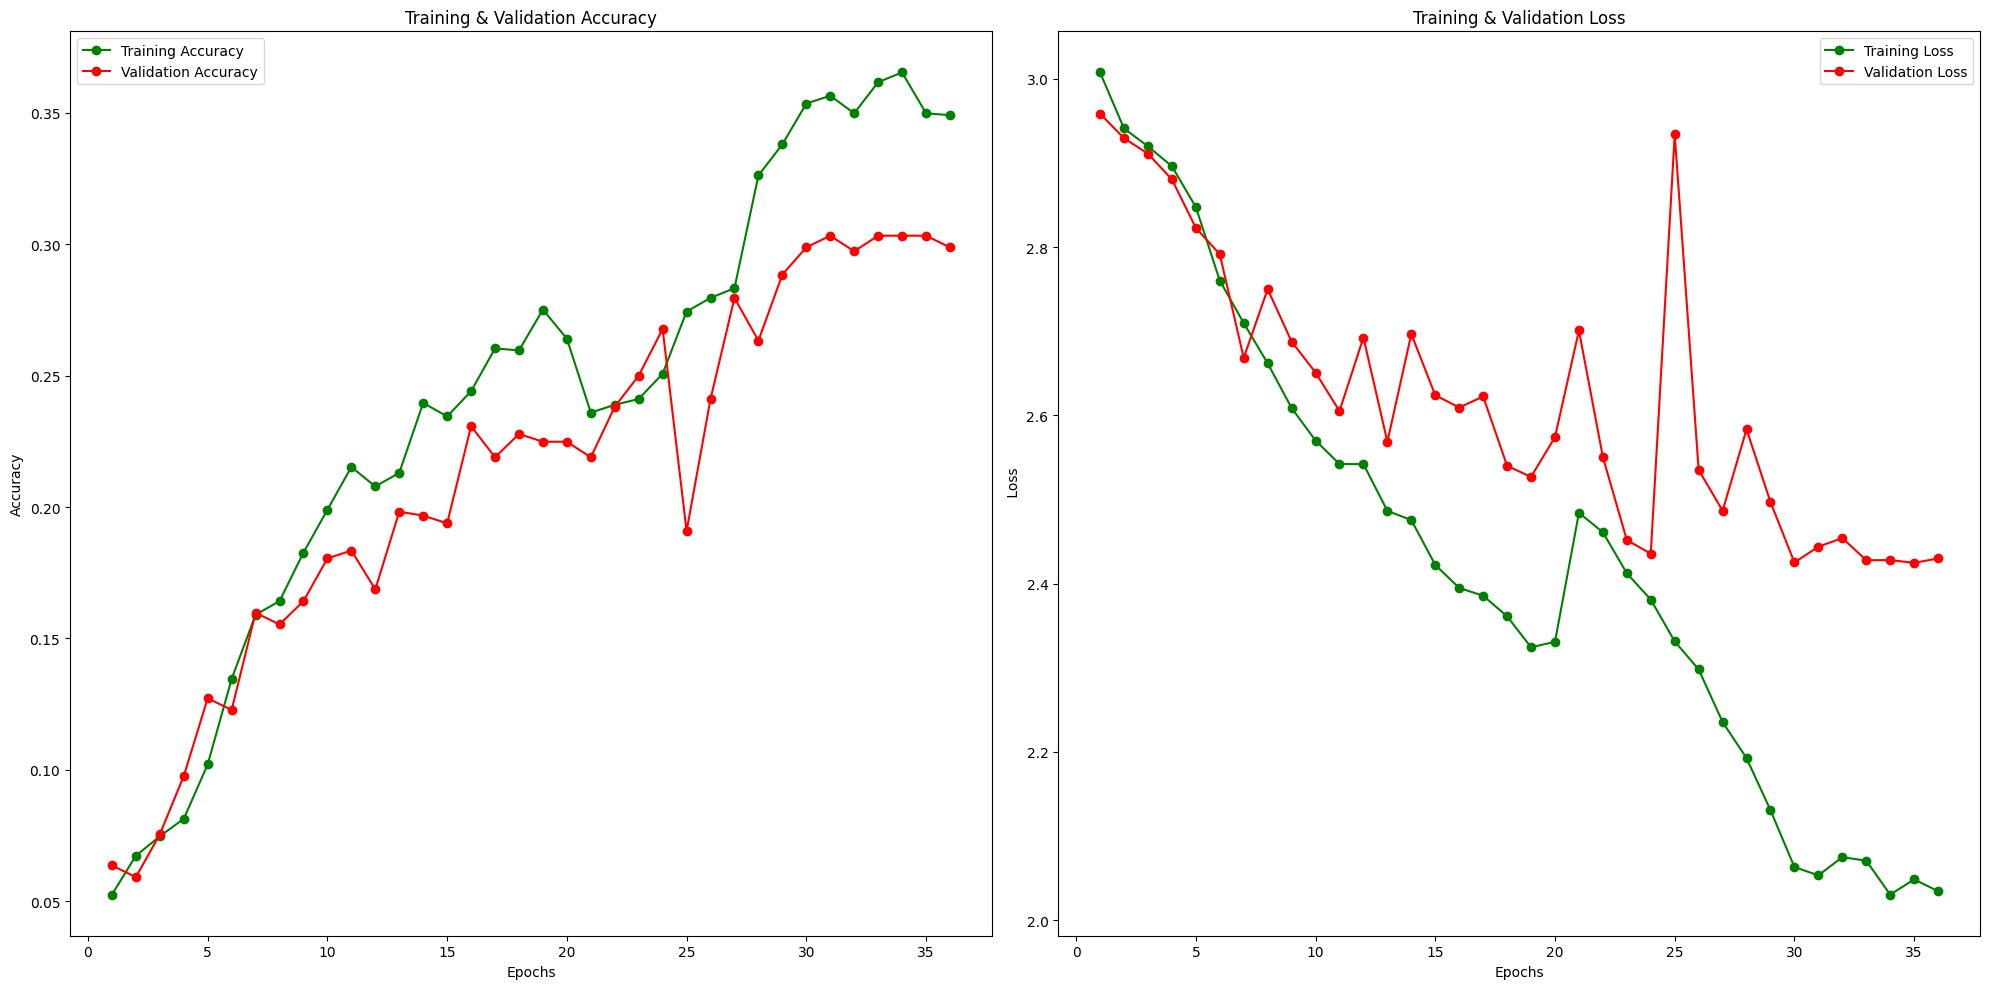

Model computation time: 0:03:22.637467
-------------------------
2-fold training
-------------------------
Found 1352 validated image filenames belonging to 18 classes.
Found 676 validated image filenames belonging to 18 classes.
Setting learning rate to 0.001
Epoch 1/20
85/85 [==============================] - 10s 112ms/step - loss: 2.2634 - accuracy: 0.2951 - val_loss: 2.2380 - val_accuracy: 0.3107 - lr: 0.0010
Setting learning rate to 0.001
Epoch 2/20
85/85 [==============================] - 11s 129ms/step - loss: 2.2267 - accuracy: 0.2944 - val_loss: 2.2822 - val_accuracy: 0.3033 - lr: 0.0010
Setting learning rate to 0.001
Epoch 3/20
85/85 [==============================] - 11s 128ms/step - loss: 2.2012 - accuracy: 0.3225 - val_loss: 2.1334 - val_accuracy: 0.3388 - lr: 0.0010
Setting learning rate to 0.001
Epoch 4/20
85/85 [==============================] - 10s 114ms/step - loss: 2.1450 - accuracy: 0.3499 - val_loss: 2.4646 - val_accuracy: 0.2574 - lr: 0.0010
Changing learning rate

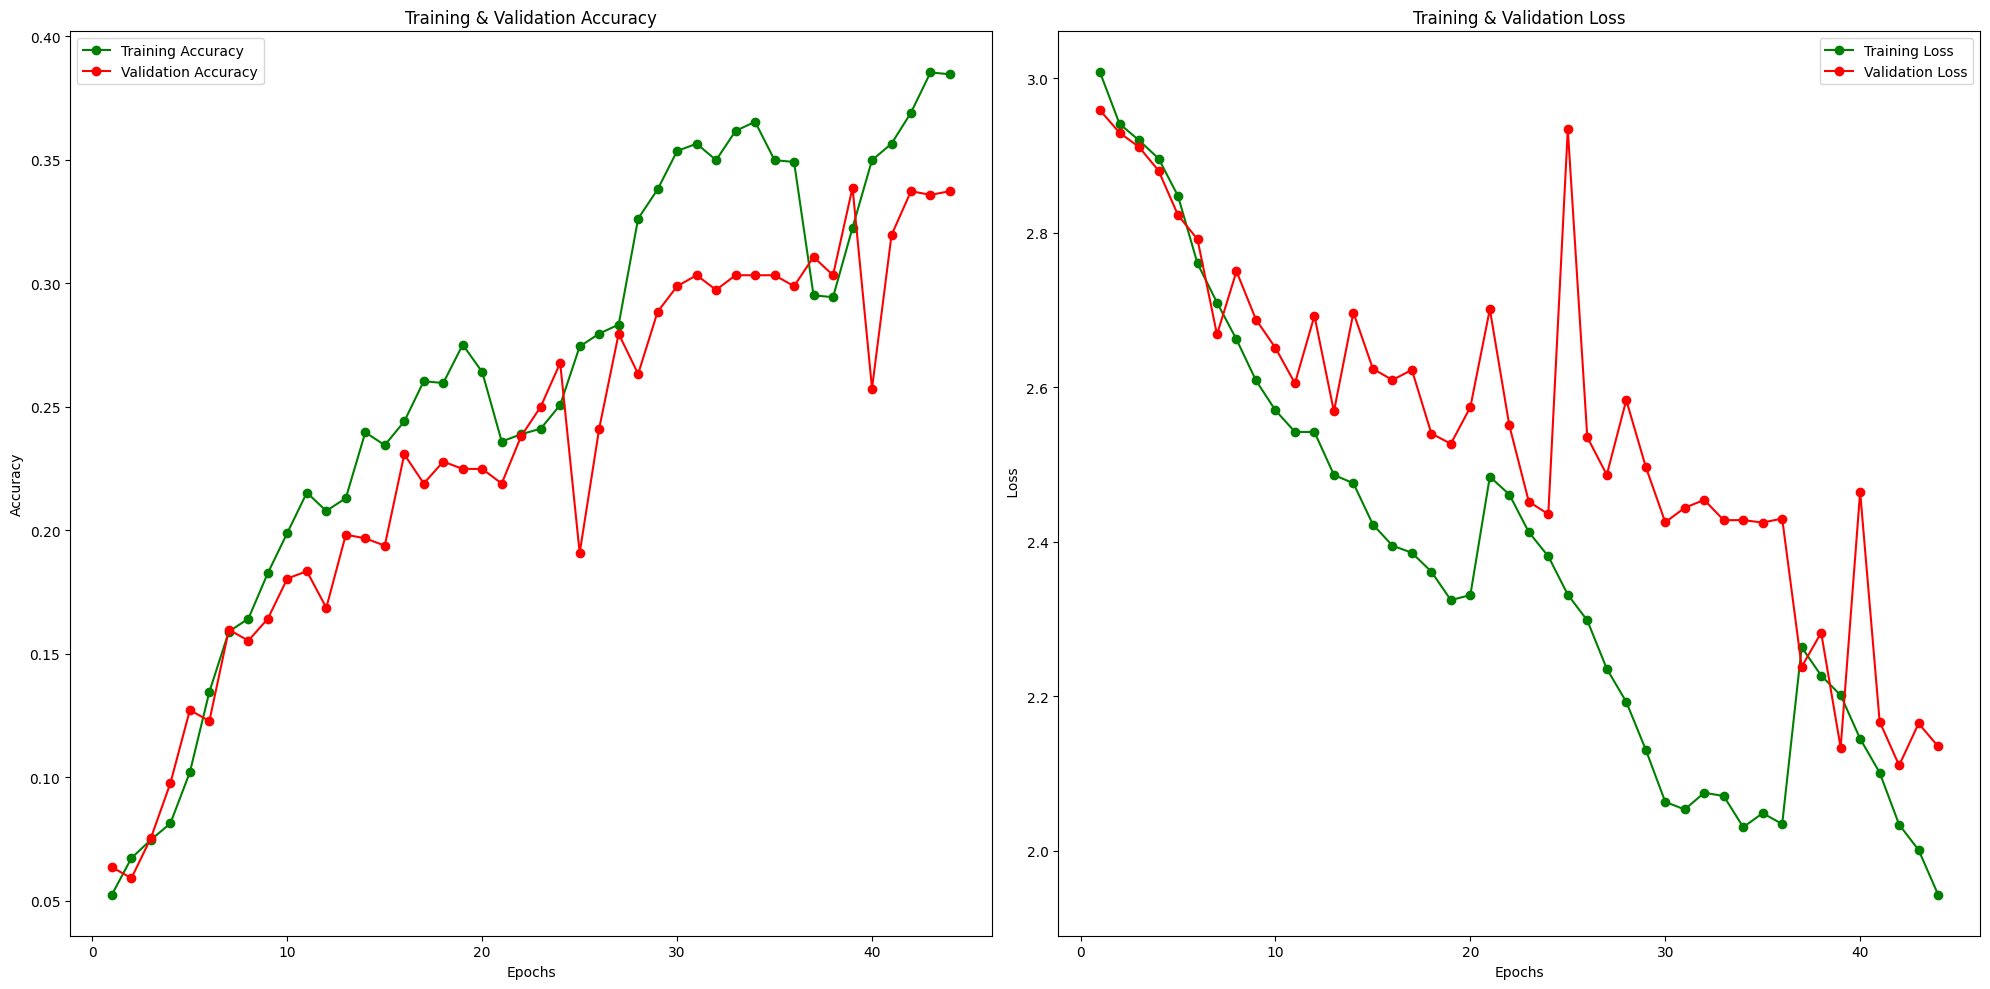

Model computation time: 0:01:46.066938


In [ ]:
# Lists to store out-of-fold (OOF) training and validation metrics for the base model
base_oof_acc=[]
base_oof_val_acc=[]
base_oof_loss=[]
base_oof_val_loss=[]

# List to store computation times for each fold
base_model_time = []

# Loop to perform 3-fold training
for i in range(3):

    # Record the start time of the current fold's training
    t1_1 = datetime.now()

    # Printing the fold number
    print(25*"-")
    print(f'{i}-fold training')
    print(25*"-")

    # Call the train_model function to train the model for the current fold
    # The train_model function seems to take parameters for data, batch size, image dimensions, fold number, and model.
    model, history, train_generator, validation_generator = train_model(data, 16, 120, 120, i, model) #Vary batch_size, img_rows, img_cols

    # Extracting accuracy and loss metrics from the training history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Appending the metrics to the OOF lists
    base_oof_acc.append(train_accuracy)
    base_oof_val_acc.append(val_accuracy)
    base_oof_loss.append(train_loss)
    base_oof_val_loss.append(val_loss)

    # Plotting training & validation accuracy and loss metrics for the current fold
    epochs = range(1, len(train_accuracy) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.set_size_inches(20,10)

    ax1.plot(epochs , train_accuracy , 'go-' , label = 'Training Accuracy')
    ax1.plot(epochs , val_accuracy , 'ro-' , label = 'Validation Accuracy')
    ax1.set_title('Training & Validation Accuracy')
    ax1.legend()
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")

    ax2.plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax2.plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax2.set_title('Training & Validation Loss')
    ax2.legend()
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel(" Loss")

    fig.tight_layout()
    plt.show()

    # Record the end time of the current fold's training and compute the duration
    t2_1 = datetime.now()
    base_model_time.append(str(t2_1 - t1_1))
    print("Model computation time: " + str(t2_1 - t1_1))

In [ ]:
base_acc_average_2 = [sum(sub_list) / len(sub_list) for sub_list in base_oof_acc_2]
base_val_acc_average_2 = [sum(sub_list) / len(sub_list) for sub_list in base_oof_val_acc_2]
base_loss_average_2 = [sum(sub_list) / len(sub_list) for sub_list in base_oof_loss_2]
base_val_loss_average_2 = [sum(sub_list) / len(sub_list) for sub_list in base_oof_val_loss_2]

In [ ]:
print("Average training accuracy across 3 folds with 20 epochs each -", base_acc_average_2)
print("Average validation accuracy across 3 folds with 20 epochs each -", base_val_acc_average_2)
print("Average training loss across 3 folds with 20 epochs each -", base_loss_average_2)
print("Average validation loss across 3 folds with 20 epochs each -", base_val_loss_average_2)

Average training accuracy across 3 folds with 20 epochs each - [0.2577830830758268, 0.2577830830758268, 0.2577830830758268]
Average validation accuracy across 3 folds with 20 epochs each - [0.23090370939197866, 0.23090370939197866, 0.23090370939197866]
Average training loss across 3 folds with 20 epochs each - [2.372926812280308, 2.372926812280308, 2.372926812280308]
Average validation loss across 3 folds with 20 epochs each - [2.5458726503632287, 2.5458726503632287, 2.5458726503632287]


In [ ]:
base_model_time_2

['0:11:09.221247', '0:03:22.637467', '0:01:46.066938']

In [ ]:
print("KFold Validation Accuracy: ", np.hstack(base_oof_acc_2).mean())

KFold Validation Accuracy:  0.2577830830758268


In [ ]:
Y_pred = model_2.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = list(train_generator.class_indices.keys()) # Classes
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

         Bug       0.08      0.05      0.06        38
        Dark       0.30      0.50      0.37        38
      Dragon       0.29      0.10      0.15        39
    Electric       0.44      0.11      0.17        38
       Fairy       0.53      0.68      0.60        38
    Fighting       0.15      0.08      0.11        37
        Fire       0.46      0.53      0.49        36
      Flying       0.57      0.95      0.71        38
       Ghost       0.50      0.08      0.13        39
       Grass       0.34      0.68      0.45        38
      Ground       0.11      0.05      0.07        37
         Ice       0.50      0.44      0.47        36
      Normal       0.18      0.29      0.22        38
      Poison       0.28      0.50      0.36        36
     Psychic       0.50      0.20      0.29        35
        Rock       0.33      0.03      0.05        38
       Steel       0.25      0.26      0.25        39
     

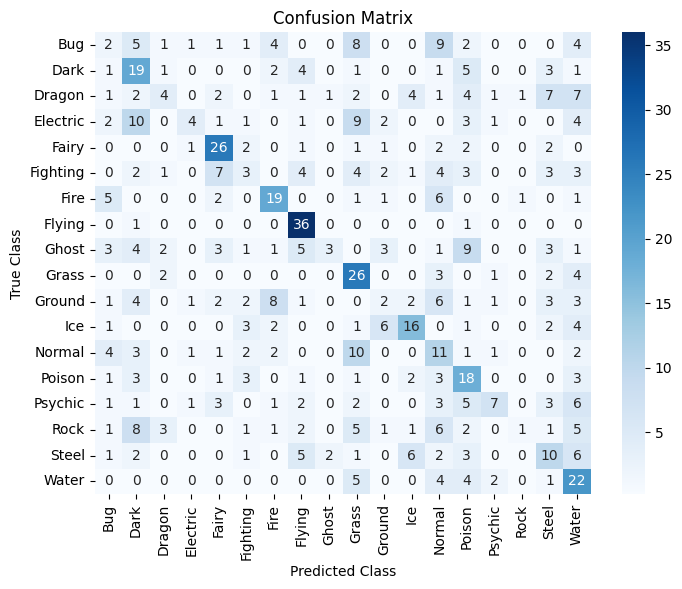

In [ ]:
cm = confusion_matrix(validation_generator.classes, y_pred)
labels = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
       'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
       'Psychic', 'Rock', 'Steel', 'Water']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

1/1 [==============================] - 0s 22ms/step


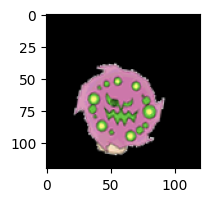

Predicted Class: Ghost
True Class: Ghost


In [ ]:
# list of class names in the correct order
class_names = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
               'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
               'Psychic', 'Rock', 'Steel', 'Water']

# Function to visualize predictions
def visualize_prediction(image, predicted_label, true_label):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.show()

    # Get the index of the predicted class (class with the highest probability)
    predicted_class_index = np.argmax(predicted_label)

    # Get the index of the true class (class with value 1 in the one-hot encoded array)
    true_class_index = np.argmax(true_label)

    # Get the predicted and true class names
    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    print('Predicted Class:', predicted_class_name)
    print('True Class:', true_class_name)

#  validation data generator
index_to_visualize = 4

# Fetch the test image and true label from the validation_generator
for i, (X_val_batch, y_val_batch) in enumerate(validation_generator):
    if i == index_to_visualize:
        test_image = X_val_batch[0]  # Assuming batch size is 1
        true_label = y_val_batch[0]  # Assuming batch size is 1
        break

# Normalize the test image (if needed)
test_image_normalized = test_image / 255.0

# Get the model's prediction for the test image
predicted_label = model_2.predict(test_image_normalized.reshape(1, 120, 120, 3))

# Visualize the test image and its predicted class
visualize_prediction(test_image, predicted_label, true_label)


1/1 [==============================] - 0s 22ms/step


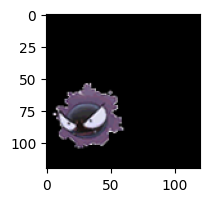

Predicted Class: Ghost
True Class: Ghost


In [ ]:
# list of class names in the correct order
class_names = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
               'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
               'Psychic', 'Rock', 'Steel', 'Water']

# Function to visualize predictions
def visualize_prediction(image, predicted_label, true_label):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.show()

    # Get the index of the predicted class (class with the highest probability)
    predicted_class_index = np.argmax(predicted_label)

    # Get the index of the true class (class with value 1 in the one-hot encoded array)
    true_class_index = np.argmax(true_label)

    # Get the predicted and true class names
    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    print('Predicted Class:', predicted_class_name)
    print('True Class:', true_class_name)

#  validation data generator
index_to_visualize = 2

# Fetch the test image and true label from the validation_generator
for i, (X_val_batch, y_val_batch) in enumerate(validation_generator):
    if i == index_to_visualize:
        test_image = X_val_batch[0]  # Assuming batch size is 1
        true_label = y_val_batch[0]  # Assuming batch size is 1
        break

# Normalize the test image (if needed)
test_image_normalized = test_image / 255.0

# Get the model's prediction for the test image
predicted_label = model_2.predict(test_image_normalized.reshape(1, 120, 120, 3))

# Visualize the test image and its predicted class
visualize_prediction(test_image, predicted_label, true_label)


1/1 [==============================] - 0s 23ms/step


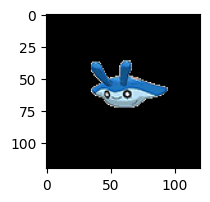

Predicted Class: Ghost
True Class: Water


In [ ]:
# list of class names in the correct order
class_names = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
               'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
               'Psychic', 'Rock', 'Steel', 'Water']

# Function to visualize predictions
def visualize_prediction(image, predicted_label, true_label):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.show()

    # Get the index of the predicted class (class with the highest probability)
    predicted_class_index = np.argmax(predicted_label)

    # Get the index of the true class (class with value 1 in the one-hot encoded array)
    true_class_index = np.argmax(true_label)

    # Get the predicted and true class names
    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    print('Predicted Class:', predicted_class_name)
    print('True Class:', true_class_name)

#  validation data generator
index_to_visualize = 8

# Fetch the test image and true label from the validation_generator
for i, (X_val_batch, y_val_batch) in enumerate(validation_generator):
    if i == index_to_visualize:
        test_image = X_val_batch[0]  # Assuming batch size is 1
        true_label = y_val_batch[0]  # Assuming batch size is 1
        break

# Normalize the test image (if needed)
test_image_normalized = test_image / 255.0

# Get the model's prediction for the test image
predicted_label = model_2.predict(test_image_normalized.reshape(1, 120, 120, 3))

# Visualize the test image and its predicted class
visualize_prediction(test_image, predicted_label, true_label)


1/1 [==============================] - 0s 24ms/step


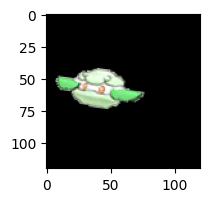

Predicted Class: Ghost
True Class: Grass


In [ ]:
# list of class names in the correct order
class_names = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
               'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
               'Psychic', 'Rock', 'Steel', 'Water']

# Function to visualize predictions
def visualize_prediction(image, predicted_label, true_label):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.show()

    # Get the index of the predicted class (class with the highest probability)
    predicted_class_index = np.argmax(predicted_label)

    # Get the index of the true class (class with value 1 in the one-hot encoded array)
    true_class_index = np.argmax(true_label)

    # Get the predicted and true class names
    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    print('Predicted Class:', predicted_class_name)
    print('True Class:', true_class_name)

#  validation data generator
index_to_visualize = 0

# Fetch the test image and true label from the validation_generator
for i, (X_val_batch, y_val_batch) in enumerate(validation_generator):
    if i == index_to_visualize:
        test_image = X_val_batch[0]  # Assuming batch size is 1
        true_label = y_val_batch[0]  # Assuming batch size is 1
        break

# Normalize the test image (if needed)
test_image_normalized = test_image / 255.0

# Get the model's prediction for the test image
predicted_label = model_2.predict(test_image_normalized.reshape(1, 120, 120, 3))

# Visualize the test image and its predicted class
visualize_prediction(test_image, predicted_label, true_label)


**GRAD-CAM**

In [ ]:
# Raphael Meudec (2019), Github. Available at https://github.com/sicara/tf-explain/blob/master/examples/core/grad_cam.py (Accessed on 30 July 2023)

# Define the path to the image you want to analyze
IMAGE_PATH = "/content/drive/MyDrive/Colab Notebooks/images2/zweilous_0_5957.png"

# Ensure this script only runs if executed, not when imported
if __name__ == "__main__":

    # Load the VGG16 model with ImageNet weights, including the fully connected layers (include_top=True)
    model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)

    # Load the image from the specified path and resize it to VGG16's expected input size
    img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))

    # Convert the PIL Image to a numpy array
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Display the architecture summary of the VGG16 model
    model.summary()

    # Prepare the data for prediction
    data = ([img], None)

    # The index for tabby cat in ImageNet is 281 (this can be any class index based on your target)
    tabby_cat_class_index = 281

    # Instantiate a GradCAM explainer
    explainer = GradCAM()

    # Compute GradCAM for the specified class index  using the 'block5_conv3' layer of VGG16
    grid = explainer.explain(
        data, model, class_index=tabby_cat_class_index, layer_name="block5_conv3"
    )

    # Save the GradCAM visualization to a file
    explainer.save(grid, ".", "Dark_class2.png")

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     